# 매일 한번씩 읽고 진행하기

# 2022.11.07(월)


- val_acc 0.23으로 끝낸건 미친짓임. 아무것도 안한거나 마찬가지
- 성능 개선은 레퍼런스만 갖다 짜집기하는 것이 아니라 일단 코드가 정상적으로 돌아가는지 그거부터 확인해서 acc 0.6, 0.7부터 뽑은다음에 전이학습할때 레이어 동결시키고 하나씩 풀면서 학습하거나 라벨 스무싱쓰거나 augmentation이나 앙상블 쓰는 걸 말하는 것
- 224 224사이즈에 64배치 돌리면 gpu금방 터진다. 노트북에서 돌리면 64면 절대 못돌림
- 정규화도 0\~1 뿐 아니라 -1~1도 해볼것
- **직접 코드 짜서 32x32x3 상태로 돌려봐라**
- 베이스 코드가 왜 중요한지, 데이콘에서 왜 베이스 라인을 주냐면 일단 코드 자체가 안틀리고 안정적안정적안정적으로 학습되는걸 검증해주면서 그 상태로 유지하라고 주는 것이다. 안정적으로 모든 코드가 정상적으로 잘 동작하는지 프로세스에 문제가 없는지를 확실하게 보는것
- 근데 난 다 추가해놓고 acc 이상하니까 어디서 고쳐야할지를 모름 => 베이스라인이 제대로 안잡혀있으니 어딜 고쳐야할지를 못찾는다. 감당도 못하게 함수 이것저것 콜백 다 박아놓으니 어디서 에러났는지 당연히 못찾지
- 그리고 learning rate dacay 저렇게 박아놓으면 당연히 학습이 안됨. 초기 lr도 0.0001인데 에폭 늘리고 decay 좀더 완만하게 
  - epochs % 10 == 0: return lr*0.88 이런식으로 200에폭 돌리면 안정될듯.
  - 0.001도 아니고 lr 0.0001로 10에폭만에 저 최하단 dense레이어가 안정이 되나??? 거기다 efficientnet에 trainable 고정도 안했으니 다 바뀔텐데 그 상태에서 dense가 학습이 될까?? 단 1에폭만에?? learning rate는 계속 줄텐데??

- **가장 베이스라인부터 cnn 몇개 쌓아서 해보고 acc 0.4, 0.5 나온거 보고 그 다음부터 하나씩 개선해볼 것**
- **겉으로 보이는 코드가 중요한게 아니다. 막 갖다 붙힌다고 다 좋은게 아니다. cnn학습이 10에폭만에 끝날거였으면 사람들이 한달동안 학습을 돌리고 그리드서치 돌리고 얼리스탑 100회 걸고 에폭 1000번을 넣을까. 난 지금 경험부족+겉멋이다**
- **남이 짜준 모델에 남이 짜준 decay 남이 짜준 generator 그런거 쓰지 말고 나 혼자서 내가 스스로 생각해서 augmentation도 직접 해보고 이미지 저장해서 불러도 와보고 내가 직접 삽질을 해야 의미가 있다. 남이 쓴 코드 다 가져다쓰고 그거 고치느라 하루 날리면 그건 삽질이 아니다**
- cifar10 학습 제대로 안되서 loss 하나 metric 하나 layer 하나 바꿔가면서 새 주피터만 30개 넘게 피고 베이스 라인 직접 짠 코드 가져와서 하나씩 수정하고 output찍고 loss에서 무슨 차이가 있는지 검색 정리 테스트 수십번을 했다
- lr decay, augmentation, earlystop 다 성능 개선 기법인데 기초도 안되는데 개선부터 하려는건 말이 안된다
- **일단 어느정도 학습이 되는걸 보고 전이학습 포함해서 내가 짠 코드가 돌아가는지 정상인지 그걸 알아야 개선을 할수 있지 않을까??**
- 제출해야할 결과물에는 내가 얼마나 삽질할 수 있고 방향이 맞는지 얼마나 탐구하려는지가 들어있어야 한다
- **레퍼런스 참고는 나중에 하고 내 코드가 정상적으로 학습시킬 수 있는지 그것부터 검증하라. 그리고 하나씩 추가해라. 추가할때마다 뭐가 달라지고 뭐가 좋아지는지, 어디서 문제가 났는데 이거여서 고쳤다든지 등 다 정리해라**
- 내 지금 접근하는 방식 자체가 잘못됨. 그래프 하나 놓고 검증이라 하지말고 지표까지 똑바로 정리해서 제대로 검증할 것. loss만 준다고 검증 끝이 아니다



## 라이브러리 셋팅 데이터 로드

- 라이브러리 임포트시 여러 방법이 있다


1. 
```
from keras.layers import Dense
output_layer = Dense(10)
```



2. 
```
from tensorflow.keras.layers import Dense 
output_layer = Dense(10)
```

3. 
```
from tensorflow import keras
output_layer = keras.layers.Dense(10) 
ㄴ> 좀 길지만 어떤 패키지를 사용하는지 쉽게 알 수 있고 표준 클래스와 
사용자 정의 클래스 사이 혼란을 피할수 있으므로 핸즈온 저자는 이방식을 선호.
```
4. 
```
from tensorflow.keras import import
output_layer = layers.Dense(10)
```







In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Concatenate,GlobalAveragePooling2D, ZeroPadding2D 
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop
from keras.losses import SparseCategoricalCrossentropy

In [2]:
# loss,acc 시각화
def show_loss_acc(history, acc_scale,loss_scale):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='train')
    plt.plot(val_acc, label='val')
    plt.xlabel('epoch')
    plt.ylabel('accurcay')
    plt.ylim(acc_scale)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(loss_scale)
    plt.legend()

In [3]:
# 데이터 로드 및 간단한 전처리
# (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
# (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0 # 0~1 정규화, 넘파이 브로드캐스팅 이용

# 검증셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

169001437/169001437 [==============================] - 13s 0us/step


((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

## OpenCV로 이미지 다루기

### 이미지 읽어오기 및 시각화

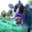

In [ ]:
# jpg, png같은 이미지라면 cv2.imread()를 이용해서 넘파이배열로 가져와 이미지를 읽어오지만 이미 넘파이 배열이므로 
# 바로 이미지를 출력할 수 있다
img = X_train[0]
cv2_imshow(img)

In [ ]:
# 이미지 jpg/png파일로 저장
# jpg는 1.4k, png는 2.58k
# png는 무손실 압축, 용량이 높고 이미지 품질이 높으며 / jpg는 질이 떨어지나 적은 용량
cv2.imwrite('img.png', img)

True

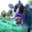

In [ ]:
cow = cv2.imread('/content/img.png')
cv2_imshow(cow)

In [ ]:
size = cow.shape # = (32, 32, 3)
# 행렬의 일부만 가져옴 = 이미지 자르기. n등분 하려몬 가로,세로 크기 나눈다
cow_trimming = cow[:size[0]//2, : size[1]//3] # cow[:size[0]//2, : size[1]//3].shape = (16, 10, 3)
cv2_imshow(cow_trimming)

- cow[ :  ,  :  ,  :  ] 
- 32 x 32 x 3의 3차원 이미지
- cow의 1차원은 0\~31, 2차원은 0\~31, 3차원은 0~2
- 픽셀의 수가 담겨져있는 행렬 자체를 빼버리면 이미지를 자르는것과 같다

In [ ]:
# 가로 세로 1/3로 축소 
cow_small_resize = cv2.resize(cow, (cow.shape[1]//3, cow.shape[0]//3))
cv2_imshow(cow_small_resize)

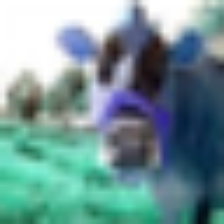

In [ ]:
cow_big_resize = cv2.resize(cow, (224,224))
cv2_imshow(cow_big_resize)

- 이미지 증강할 때 더 추가로 이미지 처리 해볼것.

### 넘파이 데이터셋 => 이미지(jpg,png) 데이터셋 생성

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 4s 0us/step


In [ ]:
!mkdir train_image
!mkdir test_image

In [ ]:
# 넘파이 배열로 있는 데이터셋을 이미지 데이터셋으로 만들어보기

# 인덱스 순서대로 정렬하기 위해서 자릿수 맞춰주기 
for idx, img in enumerate(X_train):
    if len(str(idx)) == 1:
        cv2.imwrite(f'/content/train_image/img_0000{idx}.jpeg', img)
    elif len(str(idx)) == 2:
        cv2.imwrite(f'/content/train_image/img_000{idx}.jpeg', img)
    elif len(str(idx)) == 3:
        cv2.imwrite(f'/content/train_image/img_00{idx}.jpeg', img)
    elif len(str(idx)) == 3:    
        cv2.imwrite(f'/content/train_image/img_0{idx}.jpeg', img)
    else:
        cv2.imwrite(f'/content/train_image/img_{idx}.jpeg', img)

for idx, img in enumerate(X_test):
    if len(str(idx)) == 1:
        cv2.imwrite(f'/content/test_image/img_0000{idx}.jpeg', img)
    elif len(str(idx)) == 2:
        cv2.imwrite(f'/content/test_image/img_000{idx}.jpeg', img)
    elif len(str(idx)) == 3:
        cv2.imwrite(f'/content/test_image/img_00{idx}.jpeg', img)
    elif len(str(idx)) == 3:    
        cv2.imwrite(f'/content/test_image/img_0{idx}.jpeg', img)
    else:
        cv2.imwrite(f'/content/test_image/img_{idx}.jpeg', img)

In [ ]:
# 개수 동일. 잘 만들어짐
len(os.listdir('/content/train_image')), len(os.listdir('/content/test_image'))

(50000, 10000)

In [ ]:
# 이미지 파일 경로들을 담은 리스트 만들기 
train_image_filenames = sorted(os.listdir('/content/train_image'))
test_image_filenames = sorted(os.listdir('/content/test_image'))

train_path = '/content/train_image/'
test_path = '/content/test_image/'
train_image_paths, test_image_paths = [], []

for filename in tqdm(train_image_filenames):
    train_image_paths.append(train_path + filename)

for filename in tqdm(test_image_filenames):
    test_image_paths.append(test_path + filename)

100%|██████████| 10000/10000 [00:00<00:00, 977146.58it/s]


## 모델링

### 간단한 CNN 직접 쌓아보기

### Sequential API로 모델 만들기

- 핸즈온 10장 
  
  10.2.2 시퀀셜 API로 이미지 분류기 만들기 371p~ 참고함

In [ ]:
input_shape = (32,32,3)

# Sequential 모델 먼저 선언하고 add로 모델 쌓기
model = Sequential()
# Conv2D + activation
model.add(Conv2D(32,3, padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
# Conv2D + Activation
model.add(Conv2D(64,3, padding='valid'))
model.add(Activation('relu'))
# MaxPooling2D
model.add(MaxPooling2D(2,2))
# Dropout
model.add(Dropout(0.25))
# Flatten - Dense층에 넣기 위해.
model.add(Flatten()) # => 입력 이미지를 1D 배열로 변환 = data.reshape(-1, 32*32)
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))

- 핸즈온 385page 함수형 API 코드를 참고해서 위의 시퀀셜 모델을 함수형으로 바꿔보았다

In [ ]:
input_ = keras.layers.Input(input_shape)
conv1 = keras.layers.Conv2D(32,3,activation='relu')(input_)
conv2 = keras.layers.Conv2D(64,3,activation='relu')(conv1)
maxpool1 = keras.layers.MaxPooling2D(2,2)(conv2)
dropout1 = keras.layers.Dropout(0.25)(maxpool1)
flatten = keras.layers.Flatten()(dropout1)
dense1 = keras.layers.Dense(128, activation='relu')(flatten)
dropout2 = keras.layers.Dropout(0.5)(dense1)
output = keras.layers.Dense(100, activation='softmax')(dropout2)
model_f = keras.Model(inputs=input_, outputs=output)
model_f.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                             

In [ ]:
model.summary() # None은 배치 크기에 어떤 값도 가능하다는 의미

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                        


```
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy'
```
ㄴ> 이렇게 compile에서 문자열로 명시하는 것보다

<br/>

```
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
```
ㄴ> 이렇게 사용할 loss와 optimizer를 불러오고 사용하자. 하이퍼파라미터를 조정함으로 더 세세한 모델링이 가능하다.



In [ ]:
loss = SparseCategoricalCrossentropy()
optimizer = Adam()
# loss = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # <= 이렇게 
model.fit(X_train, y_train,validation_split=0.2, batch_size=16, epochs=50, shuffle=True)

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 5.0155 - accuracy: 0.0155


[5.015457630157471, 0.01549999974668026]

In [ ]:
# Sequential 안에 add없이 바로 쌓기
model1 = Sequential([
    Conv2D(32,3,input_shape=input_shape, activation='relu'),
    Conv2D(64,3,input_shape=input_shape, activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               1605760   
                                                      

- validation_data = (X_val, y_val) 이렇게 검증 셋을 넣거나 validation_split = 0.2 이렇게 검증에 사용할 훈련 세트의 비율을 지정할 수 있다
- validation_split = 0.2를 쓰면 케라스는 검증에 (섞기전의) 데이터의 마지막 10%를 사용한다


- 어떤 클래스는 많이 등장하고 다른 클래스는 조금 등장하여 훈련 세트가 편중되어 있다면 fit()을 할때 class_weight 매개변수를 지정하는 것이 좋다

   => 편향된 데이터일 때 class_weight를 써보자

- 적게 등장하는 클래스는 높은 가중치를 부여하고 / 많이 등장하는 클래스는 낮은 가중치를 부여한다. 케라스가 손실을 계산할 때 이 가중치를 사용한다

- 샘플별(배치단위??)로 가중치를 부여하고 싶다면 sample_weight매개변수를 지정한다(class_weight, sample_weight 모두 지정되면 케라스는 두 값을 곱해서 사용한다)



- fit() 메서드가 반환하는 History 객체에는 훈련 파라미터(history.params), 수행된 에포크 리스트(history.epoch)가 들어있다
- History의 가장 중요한 속성은 **에포크가 끝날 때 마다 훈련세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리(history.history)이다**

In [ ]:
loss = SparseCategoricalCrossentropy()
optimizer = Adam()
model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model1.fit(X_train, y_train,validation_split=0.2, batch_size=32, epochs=50, shuffle=True)

In [ ]:
model1.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 4.6055 - accuracy: 0.0100


[4.605496883392334, 0.009999999776482582]

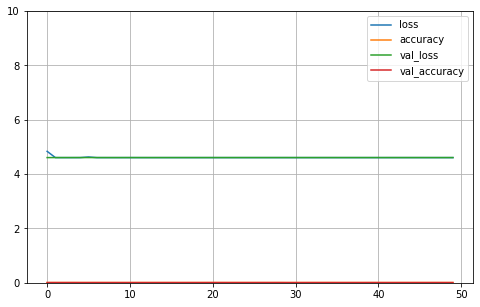

In [ ]:
# loss 그래프 0~10 사이로 볼수있게 y축 조절
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,10)
plt.show()

- Conv층 2개에 풀링 한번, 그리고 바로 Dense층. 이렇게 얇은 모델에서는 전혀 학습되지 않는다
- 층을 깊게 쌓아보면서 성능차이를 볼것.

- 모델의 predict을 통해 새로운 샘플에 대해 예측을 만들 수 있다
- predict에 데이터를 넣으면 각 라벨에 대한 확률들이 나온다.

In [ ]:
pred = model1.predict(X_test)
np.argmax(pred, axis=-1)

313/313 [==============================] - 1s 2ms/step


array([71, 71, 71, ..., 71, 71, 71])



```
# 오류 발생
predicted = model.predict_classes(X_test, verbose=0)
=> 'Sequential' object has no attribute 'predict_classes'

# 오류 해결
y_prob = model.predict(token_list, verbose=0) 
predicted = y_prob.argmax(axis=-1)
```



에러 해결 방법 : https://leunco.tistory.com/16


In [ ]:
# 모델의 레이어들을 리스트로 반환하거나 / 인덱싱해서 뽑거나 / 슬라이싱을 통해 원하는 범위의 레이어들을 가져올 수 있다
print(model1.layers) 
print(model1.layers[0])
print(model1.layers[:5])

[<keras.layers.convolutional.conv2d.Conv2D object at 0x7f50845ed1d0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f50845f3a10>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5084648dd0>, <keras.layers.regularization.dropout.Dropout object at 0x7f50845edc10>, <keras.layers.reshaping.flatten.Flatten object at 0x7f50845edc90>, <keras.layers.core.dense.Dense object at 0x7f50845edd90>, <keras.layers.regularization.dropout.Dropout object at 0x7f50845edf50>, <keras.layers.core.dense.Dense object at 0x7f5084570410>]
[<keras.layers.convolutional.conv2d.Conv2D object at 0x7f50845ed1d0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f50845f3a10>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5084648dd0>, <keras.layers.regularization.dropout.Dropout object at 0x7f50845edc10>, <keras.layers.reshaping.flatten.Flatten object at 0x7f50845edc90>]


In [ ]:
# 층의 모든 파라미터는 get_weigths(), set_weights()를 통해 접근할 수 있다
weights, biases = model1.layers[0].get_weights() # 층의 가중치와 편향을 볼 수 있다

In [ ]:
biases.shape # 편향...에 대한 밑바딥 내용이 있었는데 다시 확인할것.

(32,)



```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    **kernel_initializer='glorot_uniform',**
    **bias_initializer='zeros',**
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```

```
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    **kernel_initializer='glorot_uniform',**
    **bias_initializer='zeros',**
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```
- Dense 층은 연결 가중치를 무작위로 초기화한다. 편향은 0으로 초기화한다.
- 다른 초기화 방법을 사용하고 싶다면 층을 만들때 kernel_initializer와 bias_initializer 매개변수를 설정하면 된다
- 은닉층의 연결 가중치를 랜덤하게 초기화하는 것은 중요하다. 그렇지 않으면 제대로 학습이 되지 않을 것이다. 

  ex) 예로 모든 가중치와 편향을 0으로 초기화하면 층의 모든 뉴런이 완전히 같아지고 역전파도 뉴런을 동일하게 바꾸어 모든 뉴런이 똑같아진 채로 남는다 = 층의 뉴런이 수백개 있더라도 모델은 뉴런이 하나인 것처럼 작동한다
- 가중치를 랜덤하게 초기화하면 대칭성이 깨지므로 역전파가 전체 뉴런을 다양하게 훈련할 수 있다

  by 핸즈온 머신러닝 363page
---

- 밑바닥부터 시작하는 딥러닝1 - 6.2 가중치의 초깃값 202page도 같이 참고

- loss = "sparse_categorical_crossentropy" 와 loss = keras.losses.sparse_categorical_crossentropy를 사용하는 것은 동일하다

- optimizer = "sgd" 는 optimizer=keras.optimizers.SGD()와 동일하다

- metrics=["accuracy"]는 metrics=[keras.metrics.sparse_categorical_accuracy]와 같다

  by 핸즈온 377page

- 정답 레이블이 정수 하나로 이루어져 있고, 샘플마다 타깃 클래스 인덱스(0~9)가 하나 있고 클래스가 배타적 => sparse_categorical_crossentropy 손실 사용
- 샘플마다 클래스별 타깃 확률을 가지고 있다면(클래스 3은 [0,0,0,1,0,0,0,0,0,0])categorical_crossentropy 손실을 사용한다
- 이진분류나 다중 레이블 이진 분류는 출력층에 softmax대신 sigmoid를 사용하고 binary_crossentropy손실을 사용한다

- SGD를 사용할 때 학습률을 튜닝하는 것이 중요하다. optimizer = keras.optimizers.SGD(learning_rate=??) 원하는 값을 넣어준다

# 2022.11.08(화)

- 먼저 CIFAR100 데이터에 대해서 성능이 0.3~0.5 정도 나올때까지 혼자서 CNN을 쌓아본다. 먼저 시퀀셜로 쌓아보고 나서 함수형으로 바꿔보자.
- CNN을 쌓아볼땐 핸즈온 14장 합성곱 신경망을 사용한 컴퓨터 비전을 참고한다.
- 혼자 쌓아보고 그리고 책에 나와있는 LeNet, AlexNet, GoogLeNet, VGGNet, ResNet까지 직접 구현을 해본다
- **32x32x3 혼자 직접 쌓은 모델로 val_acc 0.6 넘기는데 데드라인은 11월 11일 금요일까지**
---

- 베이스코드가 완성되면 핸즈온 11장부터 보면서 어떻게 해야 성능향상을 시킬수 있는지 따라해보고 실험을 계속한다. 마감까지.

> 핸즈온 14장 559page

- 합성곱 층에 너무 큰 커널을 쓰는 것은 별로 좋지 않지만(5x5 한층보단 3x3 두층이 연산도 적으면서 특징 추출도 많이하고 더 좋음) 하나 예외가 있다면 첫번째 합성곱 층이다
  - 첫번째 합성곱층에선 5x5, 7x7같은 큰 커널에 2이상의 스트라이드를 쓰기도 한다
  - 이렇게 하면 너무 많은 정보를 잃지 않고 공간 방향 차원을 줄일 수 있다
  - 커널 크기를 늘려도 입력 이미지는 3개의 채널을 가지므로 비용도 크게 들지 않는다
---
- Conv층 2개에 풀링 1개 조합 => 이미지가 클수록 이 구조를 더 많이 반복할수 있음
- CNN이 출력층에 다다를수록 필터 개수가 늘어남 
  - 저수준 특성의 개수는 적지만 이를 연결하여 고수준 특성을 만들 수 있는 방법이 많기에 이런 구조가 합리적
  - 풀링 층 다음 필터 개수를 두배로 늘리는 것이 일반적

    ex) 64 -> 128 -> 256
- Dense층 사이에 과대적합을 줄이기 위해 DropOut 적용

In [ ]:
# 데이터 로드 및 간단한 전처리
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_test = X_train/255.0, X_test/255.0 # 0~1 정규화, 넘파이 브로드캐스팅 이용

# 검증셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [ ]:
hands_on_model = Sequential([
    layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=input_shape), # output = 32,32,64
    layers.MaxPooling2D(2), # 16,16,64
    layers.Conv2D(128, 3, activation='relu', padding='same'), # 16,16,128
    layers.Conv2D(128, 3, activation='relu', padding='same'), # 16,16,128
    layers.MaxPooling2D(2), # 8,8,128
    layers.Conv2D(256,3, activation='relu', padding='same'), # 8,8,256
    layers.Conv2D(256,3, activation='relu', padding='same'), # 8,8,256
    layers.MaxPooling2D(2), # 4,4,256
    layers.Flatten(), # 4096
    layers.Dense(128, activation='relu'), # [4096(입력 뉴런수) + 1(편향)] x 128(출력 뉴런수)
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'), # 
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax') 
])
# same 패딩이라서 피쳐맵 계산이 쉬웠음

In [ ]:
hands_on_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 256)        

In [ ]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()
acc = keras.metrics.SparseCategoricalAccuracy()

hands_on_model.compile(optimizer=optimizer, loss=loss, metrics=acc)

history = hands_on_model.fit(X_train, y_train,validation_data = (X_val, y_val), batch_size=16, epochs=50)

In [ ]:
hands_on_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.3044 - sparse_categorical_accuracy: 0.1000


[2.304419755935669, 0.10000000149011612]

In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

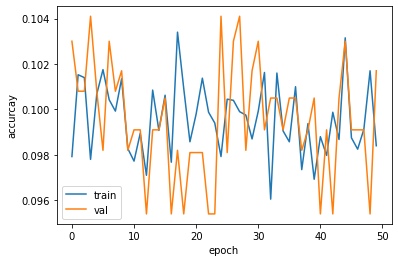

In [ ]:
acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']

plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('epoch')
plt.ylabel('accurcay')
plt.legend()

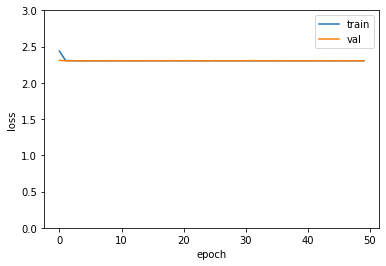

In [ ]:
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0,3)
plt.legend()

## 핸즈온 14장 모델 직접 구현하기

### LeNet-5 

- 560~561page에 있는 LeNet-5 구조만 보고 직접 구현하였다

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbvAX5s%2Fbtq9wfO9OXU%2FKLf4IceqhF9oWYChUkLSdK%2Fimg.png)

LeNet-5 구현 및 설명 : https://mldlcvmjw.tistory.com/289

In [ ]:
# 데이터 로드 및 간단한 전처리
# (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0 # 0~1 정규화, 넘파이 브로드캐스팅 이용

# 검증셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((48000, 28, 28),
 (48000,),
 (12000, 28, 28),
 (12000,),
 (10000, 28, 28),
 (10000,))

In [ ]:
# 완전 옛날 논문 구조 그대로
LeNet_5 = Sequential([
    layers.Conv2D(filters=6,kernel_size=5,strides=1,padding='valid', activation='tanh',input_shape=[28,28,1]), # 입력-C1,mnist는 28,28,1
    layers.AveragePooling2D(2, strides=2), # S2
    layers.Activation('tanh'), # S2
    layers.Conv2D(16, 5, activation='tanh'), # C3
    layers.AveragePooling2D(2, strides=2), # S4
    layers.Activation('tanh'), # S4
    layers.Conv2D(120,5, activation='tanh'), # C5
    # C5, Conv층에서 이미지 사이즈가 5x5일때 5x5필터로 1x1크기를 만들어냈는데 이거 자체가 flatten시킨거로 볼수는 없을까???
    # Flatten을 안하고 돌리면 에러가 날까? 채널 120개가 한줄로 쭉 있긴하지만 그래도 차원은 3차원으로 되있어서 에러나지 않을까?
    layers.Flatten(), # Dense넣기전 평탄화
    layers.Dense(84, activation='tanh'), # F6
    layers.Dense(10, activation='softmax') # 출력 / 책에서는 활성화함수로 RBF를 사용했지만 해당함수가 없으므로 softmax를 사용
])

LeNet_5.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d_50 (Avera  (None, 12, 12, 6)        0         
 gePooling2D)                                                    
                                                                 
 activation_48 (Activation)  (None, 12, 12, 6)         0         
                                                                 
 conv2d_91 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_51 (Avera  (None, 4, 4, 16)         0         
 gePooling2D)                                                    
                                                                 
 activation_49 (Activation)  (None, 4, 4, 16)        



```
# mnist(28x28x1) 사용시

LeNet_5 = Sequential([
    layers.Conv2D(filters=6,kernel_size=5,strides=1,padding='valid', activation='tanh',input_shape=[28,28,1]), # 입력-C1,mnist는 28,28,1
    layers.AveragePooling2D(2, strides=2), # S2
    layers.Activation('tanh'), # S2
    layers.Conv2D(16, 5, activation='tanh'), # C3
    layers.AveragePooling2D(2, strides=2), # S4
    layers.Activation('tanh'), # S4
    layers.Conv2D(120,5, activation='tanh'), # C5
    layers.Flatten(), 
    layers.Dense(84, activation='tanh'), # F6
    layers.Dense(10, activation='softmax') 
])

LeNet_5.summary()

# 에러발생
ValueError: Exception encountered when calling layer "conv2d_86" (type Conv2D).

Negative dimension size caused by subtracting 5 from 4 for '{{node conv2d_86/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", 
dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", 
strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_86/Conv2D/ReadVariableOp)' with input shapes: [?,4,4,16], [5,5,16,120].

Call arguments received by layer "conv2d_86" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 4, 4, 16), dtype=float32)

# 이 모델이 32x32x3 크기 기준으로 만들어져서 S4에서 풀링하고 나면 (5,5,16)이 나온다. 거기서 C5, Conv층에서 5x5 필터를 거쳐서 (1,1,120)이 되는건데 
처음 이미지를 28x28x1을 넣어버리면 처음 conv층 거치면 (24,24,6), 마지막 풀링층 거치면 (4,4,16)이므로 5x5필터보다 작기때문에 에러가 난다
따라서 28x28이미지를 쓰고 싶다면 처음 conv에서 패딩을 same으로 줘서 크기 유지를 시켜주면 된다

# 저 위의 링크글에서 왜 첫 conv층에서 패딩을 valid가 아니라 same을 줬나 궁금했는데 이렇게 사이즈 계산을 맞추기 위해서였다

# 에러 메세지를 보고 정확하게 해결했다기 보단 중간중간 보이는 것들, input shapes: [?,4,4,16], [5,5,16,120], 
inputs=tf.Tensor(shape=(None, 4, 4, 16), dtype=float32)
이런거 보고 때려맞춘 느낌이라 찜찜하다
```



In [ ]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()
# acc = keras.metrics.SparseCategoricalAccuracy()

es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# LeNet_5.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
LeNet_5.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = LeNet_5.fit(X_train, y_train,validation_data = (X_val, y_val), batch_size=16, epochs=20, callbacks=[es])

In [ ]:
LeNet_5.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.0095 - accuracy: 0.6633


[1.0094634294509888, 0.6632999777793884]

### AlexNet

- 핸즈온 562page

![d](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FkypYo%2FbtqE4CT5dP2%2F454RR0BmLSaMobqBzUVai1%2Fimg.png)

https://wiserloner.tistory.com/1126

- 논문에 따르면 AlexNet은
1. 8층의 구조(Conv-5층, Dense-3층)
2. 활성화 함수로 tanh 대신 Relu 사용 - CIFAR10으로 써봤다니 나도 써봐야겠다
3. GPU 여러개 사용으로 학습 시간 줄임
4. 정규화 층 도입(LRN:Local Response Normalization)
   - 일반화를 돕기위해 지역 정규화를 넣었다.
   - **'applied this normalization after applying the ReLU nonlineraity'** => 활성화 함수 거치고 나서 정규화층 넣었다
   - 얘네가 실험한거 보면 CIFAR10 많이 썼네
5. 독특한 풀링 사용 - Overlapping Pooling
   - s : stride, z : pooling filter size
   - s = z, traditional local pooling, 전통적인 풀링 방식은 스트라이드랑 풀링 필터랑 크기를 같게 준다 => 그럼 필터와 움직이는 간격이 같으므로 풀링을 할때 픽셀이 겹치지 않게 된다
   - we set s < z, overlapping pooling. s = 2 & z = 3
   - 저자는 움직이는 간격보다 필터의 크기를 더 크게 해서 픽셀들이 겹치게 해줬다. 그래서 오버래핑이다. 
   - 똑같이 준거보다 에러 발생률이 줄고 오버핏 방지에 효과가 있었다고 하네요
6. 드랍아웃. Dense층 2군데에 0.5로 적용
---
- AlexNet 구조 설명하자면
1. 정규화는 1,2번째 Conv뒤에 온다
2. 맥스풀링은 두번의 정규화랑 5번째 Conv층 뒤에 온다
  => Conv1(Relu) + LRN + MaxPooling1 / Conv2(Relu) + LRN + MaxPooling2
3. 3,4,5번째 Conv층은 풀링, 정규화가 없이 쭉 이어져있다
  => Conv3 + Conv4 + Conv5 + MaxPooling3
4. Flatten시키고 뒤에 Dense층 3개.4096,4096, 1000
---

- 한번에 정리해보자면

 => [Conv1(relu) + LRN + MaxPooling1] + [Conv2(relu) + LRN + MaxPooling2] + Conv3 + Conv4 + Conv5 + MaxPooling3 + (Flatten) + Dense1(4096) + Dense2(4096) + Dense3(1000)

In [ ]:
input_shape = [227,227,3]

AlexNet = Sequential([
    layers.Conv2D(96, 11, strides=4, activation='relu',input_shape=input_shape), # C1
    # tf.nn.local_response_normalization
    # BatchNormalization() - 그래서 AlexNet 구현 코드들을 보면 LRN 대신 BatchNormalization()을 썼구나. 정규화해주려고.
    layers.MaxPooling2D(3, 2), # 논문에서 s(stride) = 2, z(pooling filiter size) = 3 (3x3) / S2
    ########################################################
    layers.Conv2D(256, 5, activation='relu', padding='same'), # C3
    # tf.nn.local_response_normalization
    layers.MaxPooling2D(3, 2), # S4 
    #######################################################
    layers.Conv2D(384, 3, activation='relu', padding='same'), # C5
    layers.Conv2D(384, 3, activation='relu', padding='same'), # C6
    layers.Conv2D(256, 3, activation='relu', padding='same'), # C7
    layers.MaxPooling2D(3, 2), # F8
    layers.Flatten(),
    layers.Dense(4096, activation='relu'), # F9
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'), # F10
    layers.Dropout(0.5),
    layers.Dense(1000, activation='softmax'), # 출력 
])

# 2022.11.09(수)

## Simple_CNN - Learning rate에 따른 accuracy의 변화

In [ ]:
# 데이터 로드 및 간단한 전처리
# (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
# (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0 # 0~1 정규화, 넘파이 브로드캐스팅 이용

# 검증셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

# model.summary()

- 그동안 점수가 제대로 안나오던게 학습률 때문인가??
- 고정 조건 : 모델, loss, adam, earlystopping(patience=30, monitor='val_loss'), batch_size=32, epochs=100
- 실험값 : learning_rate
---
1. Adam(learning_rate=0.01) : loss: 4.6081 - accuracy: 0.0100 - 전혀 학습이 안됨
2. Adam(learning_rate=0.005) : loss: 3.4629 - accuracy: 0.1728
3. Adam(learning_rate=0.001) : loss: 2.6301 - accuracy: 0.3358
4. Adam(learning_rate=0.0005) : loss: 2.5406 - accuracy: 0.3596
5. Adam(learning_rate=0.0001) : loss: 2.5701 - accuracy: 0.3716 
6. Adam(learning_rate=0.00009) : loss: 2.6700 - accuracy: 0.3664 - EarlyStopping 동작안함. 학습률이 낮을수록 수렴하는데 오래 걸림 = 많은 epoch을 필요

- 이런 시발...그냥 모델하나두고 학습률만 바꿔봐도 바로 나오는걸 고정시켜두고 안된다고 병신짓을 하고 있으니 성재가 빡칠만 하다

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6700 - accuracy: 0.3664


[2.669999122619629, 0.36640000343322754]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## AlexNet에 사용된 기법들 적용 

### BatchNormalization층 추가(활성화 함수 뒤에)(0.3381)

- 'applied this normalization after applying the ReLU nonlineraity' => 활성화 함수 거치고 나서 정규화층 넣었다

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6900 - accuracy: 0.3381


[2.689953088760376, 0.33809998631477356]

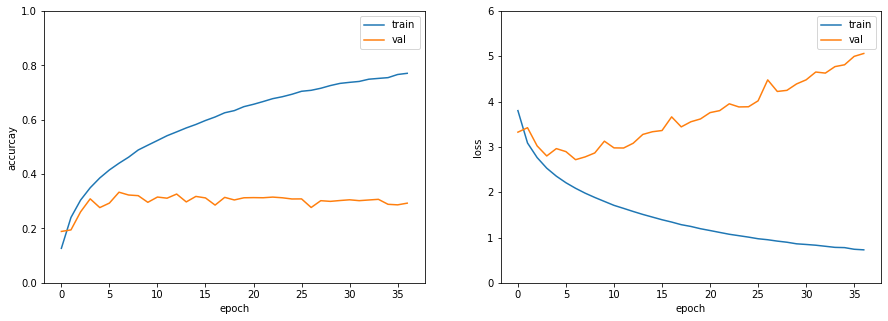

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 심플 CNN에 정규화 층만 추가해줬을 때는 큰 변화는 없었다

### MaxPooling => Overlapping 적용(0.3544)

In [ ]:
# MaxPooling => Overlapping 적용
# padding='same' 안주면 
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) # 여기서 필터보다 이미지사이즈가 더 작아서 오류남
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.5708 - accuracy: 0.3544


[2.5708250999450684, 0.35440000891685486]

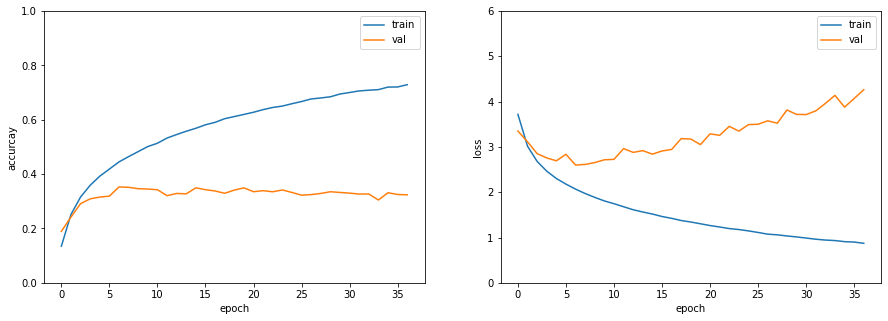

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 33 -> 35로 상승. 하지만 여전히 성능이 낮고 과적합의 문제가 있음

### AlexNet 구조 사용(0.3157)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((3, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.7440 - accuracy: 0.3157


[2.7439770698547363, 0.3156999945640564]

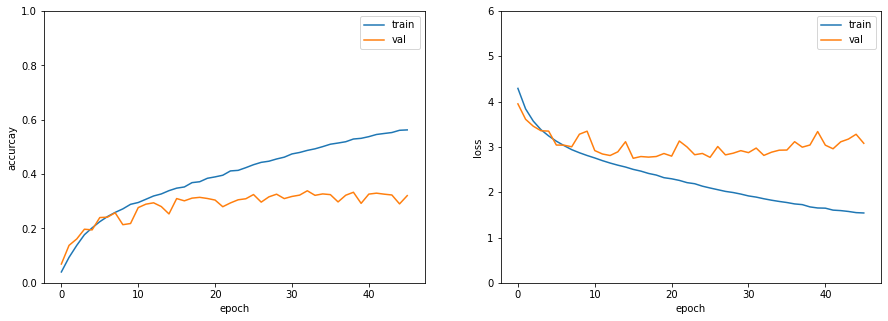

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 위의 그래프와 비교해보면 val_loss가 좀 안정화됨을 볼 수 있다

### conv 채널, dense 노드 2배로 증가(0.3421)

In [ ]:
# conv 채널과 dense 노드 개수 증가시킴
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((3, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.7216 - accuracy: 0.3421


[2.7216267585754395, 0.34209999442100525]

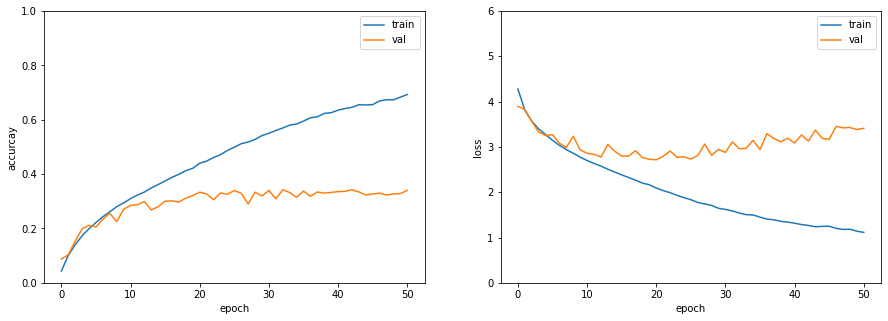

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 풀링 필터수 조절(0.3445)

In [ ]:
# 풀링 필터 3,3 사용
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((3)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6862 - accuracy: 0.3445


[2.6861610412597656, 0.34450000524520874]

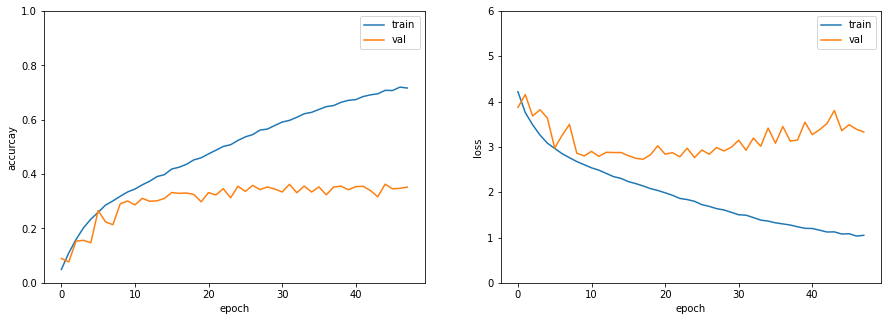

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

In [ ]:
# 풀링 필터 2,2 사용 
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.5350 - accuracy: 0.3586


[2.5350377559661865, 0.358599990606308]

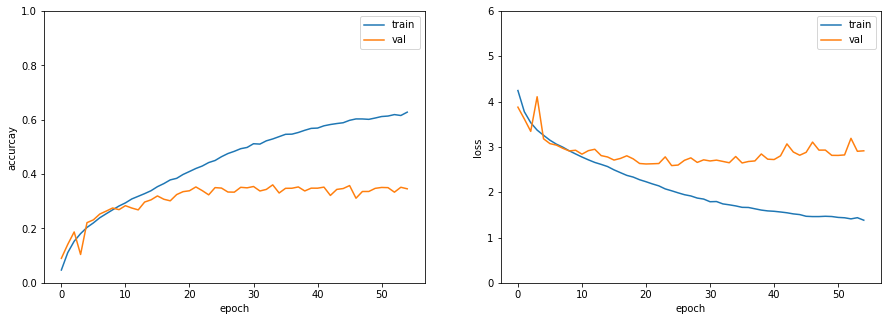

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 풀링시 3보단 2가 더 좋나?? 일단 풀링 필터 사이즈는 2로 킵

## 층을 더 깊게. Conv-Bn-pool 한 블럭 추가(0.3687)

In [ ]:

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6264 - accuracy: 0.3687


[2.626377820968628, 0.3686999976634979]

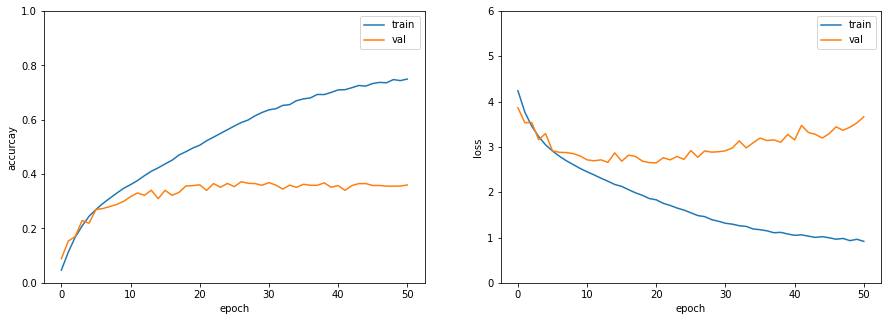

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- Conv 한블럭을 추가 했더니 미세하게 성능이 올랐다. 몇 개 더추가해보면서 얼마나 상승하는지 확인해보자

## Conv 3블럭 추가(0.3213)

In [ ]:
# Conv 3블럭 추가
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
# model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.7335 - accuracy: 0.3213


[2.73347544670105, 0.3212999999523163]

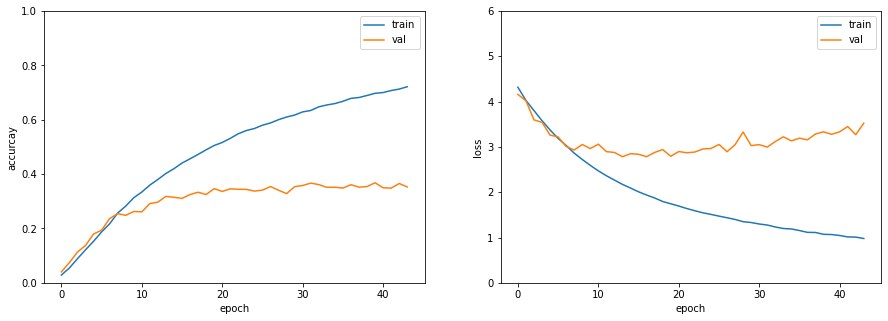

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 성능이 오히려 떨어짐... 층을 그저 많이 쌓기만 한다고 성능이 올라가지는 않는다

## conv층 2개 연속(0.3755)

In [ ]:
# conv층 2배
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.5574 - accuracy: 0.3755


[2.557366371154785, 0.37549999356269836]

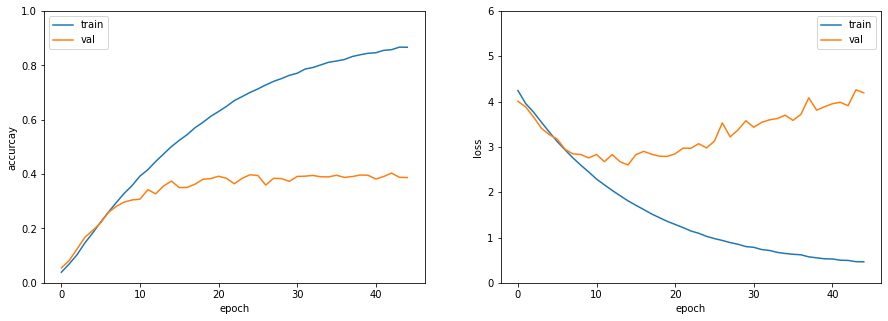

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- conv층이 한개씩 있던곳에 2개로 늘려줘서 돌렸더니 미세하게 성능증가. 하지만 과적합이 심하다.

In [ ]:
# conv2 2배, lr=0.0001
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

Epoch 1/100
1250/1250 [==============================] - 13s 9ms/step - loss: 4.2264 - accuracy: 0.0435 - val_loss: 4.0334 - val_accuracy: 0.0586
Epoch 2/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.9319 - accuracy: 0.0742 - val_loss: 3.8813 - val_accuracy: 0.0814
Epoch 3/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.7043 - accuracy: 0.1135 - val_loss: 3.9448 - val_accuracy: 0.0977
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.4827 - accuracy: 0.1504 - val_loss: 3.6128 - val_accuracy: 0.1467
Epoch 5/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.2812 - accuracy: 0.1926 - val_loss: 3.1718 - val_accuracy: 0.2160
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 3.0814 - accuracy: 0.2280 - val_loss: 3.1309 - val_accuracy: 0.2192
Epoch 7/100
1250/1250 [==============================] - 11s 9ms/step - loss: 2.9017 - accuracy: 0.2623 - val_loss: 3.0724 -

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.5103 - accuracy: 0.3840


[2.5102903842926025, 0.3840000033378601]

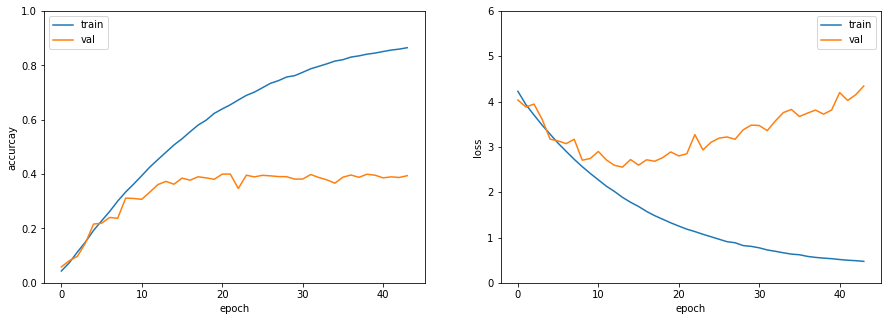

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## 위에서 여러개 쓰인 Conv를 1개로 줄임. Dense와 Dropout 한블럭 제거(0.4206) 

In [ ]:
# 위에서 여러개 쓰인 Conv를 1개로 줄임. Dense와 Dropout 한블럭 제거 
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
# Dense-dropout 한블럭 주석처리 시 loss: 2.3591 - accuracy: 0.3994
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

Epoch 1/100
1250/1250 [==============================] - 8s 6ms/step - loss: 3.9566 - accuracy: 0.0962 - val_loss: 4.2554 - val_accuracy: 0.0710
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 3.3238 - accuracy: 0.1885 - val_loss: 3.0016 - val_accuracy: 0.2452
Epoch 3/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.9127 - accuracy: 0.2624 - val_loss: 2.9659 - val_accuracy: 0.2563
Epoch 4/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.6279 - accuracy: 0.3190 - val_loss: 2.5782 - val_accuracy: 0.3317
Epoch 5/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3869 - accuracy: 0.3655 - val_loss: 2.4880 - val_accuracy: 0.3586
Epoch 6/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1765 - accuracy: 0.4144 - val_loss: 2.3743 - val_accuracy: 0.3870
Epoch 7/100
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9868 - accuracy: 0.4547 - val_loss: 2.2736 - val_ac

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.2241 - accuracy: 0.4206


[2.2241263389587402, 0.4205999970436096]

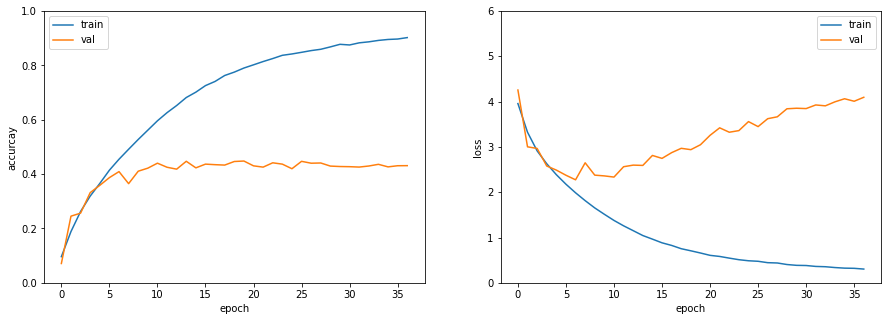

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- Conv층을 2-3개씩 연속으로 놓기보단 Conv-bn-pool 이렇게 한블럭으로 잡고 여러개로 두었는데 성능이 올라갔다
- 원인이 뭘까???

- 과적합을 억제하면서도 성능을 높일 수 있는 방법이 뭐가 있을까??? 
- 아 과적합의 문제면 **dropout**을 넣어보자



## 층 순서 변경 및 드랍아웃 추가(0.4638)

- Convolution - Batch Normalization - Activation - Dropout(0.2) - Pooling
- Dense-Dropout(0.5)

- dropout을 어디 부분에 넣는게 좋을까?? 풀링 뒤에??

- [BatchNormalization, Dropout, Pooling 적용 순서](https://gaussian37.github.io/dl-concept-order_of_regularization_term/)

- [Dropout, BatchNorm 적용 순서](https://velog.io/@redgreen/Dropout-BatchNorm-%EC%A0%81%EC%9A%A9-%EC%88%9C%EC%84%9C)

- Convolution - Batch Normalization - Activation - Dropout - Pooling

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,verbose=1, callbacks=[es])

Epoch 1/100
1250/1250 [==============================] - 10s 7ms/step - loss: 4.2570 - accuracy: 0.0527 - val_loss: 4.3487 - val_accuracy: 0.0446
Epoch 2/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.8823 - accuracy: 0.0904 - val_loss: 4.2612 - val_accuracy: 0.0581
Epoch 3/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.6521 - accuracy: 0.1238 - val_loss: 4.1042 - val_accuracy: 0.0859
Epoch 4/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.4552 - accuracy: 0.1562 - val_loss: 4.0525 - val_accuracy: 0.0789
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 3.2808 - accuracy: 0.1881 - val_loss: 4.2667 - val_accuracy: 0.0832
Epoch 6/100
1250/1250 [==============================] - 9s 7ms/step - loss: 3.1166 - accuracy: 0.2184 - val_loss: 3.3069 - val_accuracy: 0.1925
Epoch 7/100
1250/1250 [==============================] - 9s 7ms/step - loss: 2.9760 - accuracy: 0.2432 - val_loss: 3.6320 - val_a

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.0462 - accuracy: 0.4638


[2.0461761951446533, 0.46380001306533813]

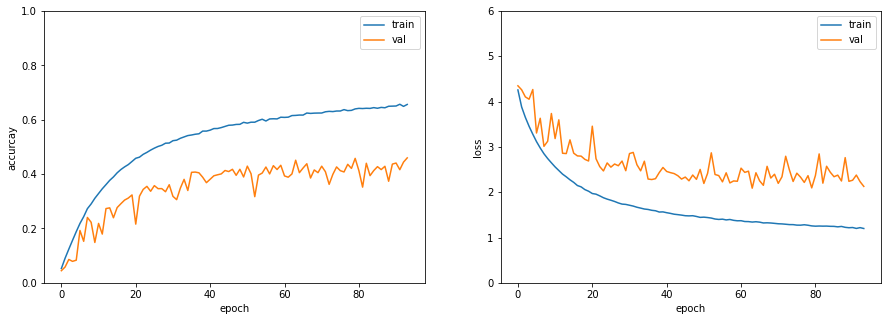

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 와.... dropout 효과가 제대로 나타났다. 전체 dropout을 0.2로 줬는데 조금더 올려도 될 것 같다

# 2022.11.10(목)

## epoch 더 늘려서 학습(0.4846)

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 10s 7ms/step - loss: 4.2574 - accuracy: 0.0520 - val_loss: 4.2142 - val_accuracy: 0.0527
Epoch 2/200
1250/1250 [==============================] - 8s 7ms/step - loss: 3.8904 - accuracy: 0.0882 - val_loss: 4.0045 - val_accuracy: 0.0760
Epoch 3/200
1250/1250 [==============================] - 8s 7ms/step - loss: 3.6664 - accuracy: 0.1231 - val_loss: 3.8094 - val_accuracy: 0.1247
Epoch 4/200
1250/1250 [==============================] - 8s 7ms/step - loss: 3.4663 - accuracy: 0.1579 - val_loss: 3.8006 - val_accuracy: 0.1079
Epoch 5/200
1250/1250 [==============================] - 9s 7ms/step - loss: 3.2684 - accuracy: 0.1937 - val_loss: 3.4487 - val_accuracy: 0.1683
Epoch 6/200
1250/1250 [==============================] - 8s 7ms/step - loss: 3.1056 - accuracy: 0.2203 - val_loss: 3.4248 - val_accuracy: 0.1758
Epoch 7/200
1250/1250 [==============================] - 8s 7ms/step - loss: 2.9469 - accuracy: 0.2519 - val_loss: 3.2712 - val_a

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.9683 - accuracy: 0.4846


[1.96826171875, 0.4846000075340271]

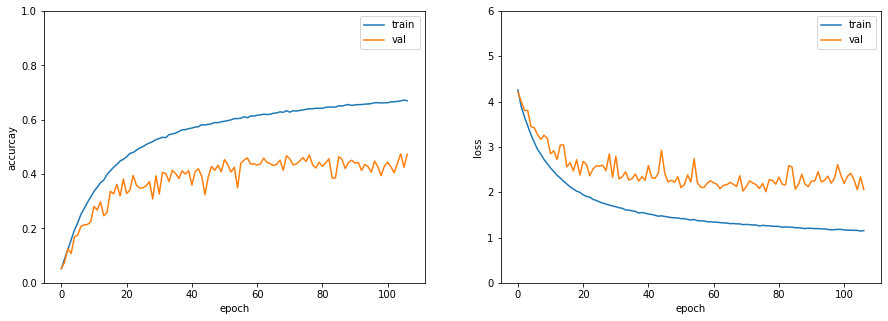

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## Conv 2개 연속으로 주기(0.4890)

- Convolution - Batch Normalization - Activation - Dropout - Pooling으로 이루어진 블럭을 하나에서 여러개 추가해보고 성능확인
- Conv층에선 패딩때문에 크기가 유지되만 32x32의 작은 이미지는 풀링층 때문에 블럭 단위로 넣는덴 한계가 있다
- 그럼 이상태에서 연속된 Conv를 넣어주면 어떻게 될까? 앞에선 Conv를 2~3개 거칠 때 성능이 조금 상승하였다

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 13s 9ms/step - loss: 4.3339 - accuracy: 0.0362 - val_loss: 4.1466 - val_accuracy: 0.0497
Epoch 2/200
1250/1250 [==============================] - 11s 8ms/step - loss: 4.0164 - accuracy: 0.0667 - val_loss: 4.2318 - val_accuracy: 0.0551
Epoch 3/200
1250/1250 [==============================] - 11s 8ms/step - loss: 3.8487 - accuracy: 0.0900 - val_loss: 3.9729 - val_accuracy: 0.0682
Epoch 4/200
1250/1250 [==============================] - 11s 8ms/step - loss: 3.7108 - accuracy: 0.1081 - val_loss: 3.9644 - val_accuracy: 0.0786
Epoch 5/200
1250/1250 [==============================] - 11s 9ms/step - loss: 3.5896 - accuracy: 0.1283 - val_loss: 3.7802 - val_accuracy: 0.1080
Epoch 6/200
1250/1250 [==============================] - 11s 9ms/step - loss: 3.4593 - accuracy: 0.1500 - val_loss: 3.7262 - val_accuracy: 0.1227
Epoch 7/200
1250/1250 [==============================] - 11s 9ms/step - loss: 3.3284 - accuracy: 0.1703 - val_loss: 3.8375 -

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.9831 - accuracy: 0.4890


[1.983064889907837, 0.48899999260902405]

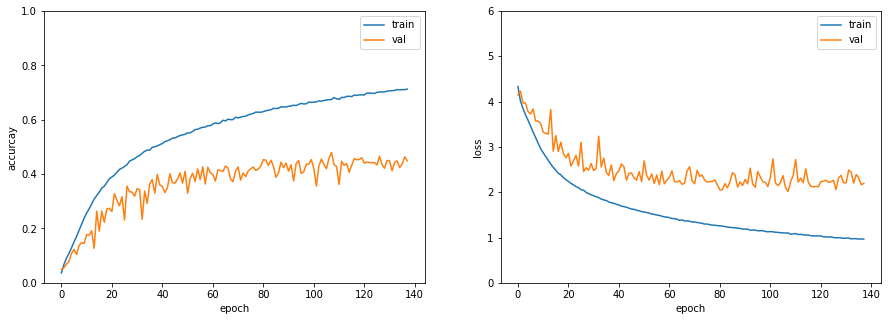

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 정확도는 그대로, 과적합이 조금 심해짐
- Conv층은 하나에서 노드수를 올려보는 것도 좋을것같다

## Conv 채널 2배 늘리기(0.4603)

- 위의 epoch 더 늘려서 학습(0.4846) 모델을 가져와 합성곱계층 채널을 2배로 주었다

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model = Sequential()
model.add(layers.Conv2D(128, (3, 3),padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Conv2D(256, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 16s 12ms/step - loss: 4.3010 - accuracy: 0.0408 - val_loss: 4.2112 - val_accuracy: 0.0450
Epoch 2/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.9838 - accuracy: 0.0709 - val_loss: 4.0679 - val_accuracy: 0.0680
Epoch 3/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.7896 - accuracy: 0.0964 - val_loss: 3.9653 - val_accuracy: 0.0950
Epoch 4/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.5675 - accuracy: 0.1288 - val_loss: 3.7167 - val_accuracy: 0.1269
Epoch 5/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.3645 - accuracy: 0.1613 - val_loss: 3.8061 - val_accuracy: 0.1131
Epoch 6/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.1710 - accuracy: 0.1948 - val_loss: 3.5765 - val_accuracy: 0.1633
Epoch 7/200
1250/1250 [==============================] - 15s 12ms/step - loss: 2.9890 - accuracy: 0.2296 - val_loss: 3

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.0837 - accuracy: 0.4603


[2.083735942840576, 0.4602999985218048]

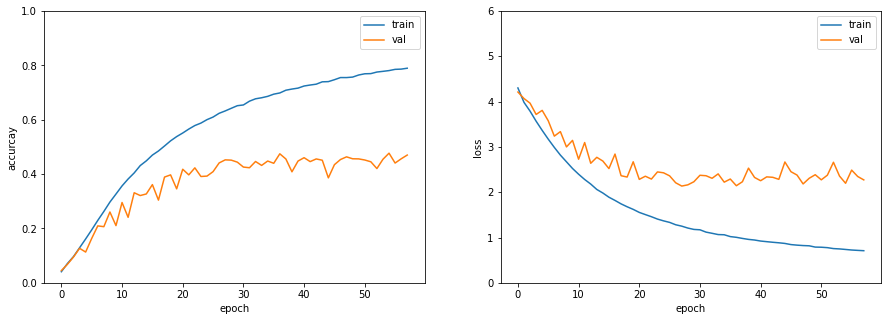

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 음....크게 좋아지진 않았다..
- 뭘 더 추가해줘야 할까???
- 풀링때문에 블럭단위로 추가해줄 수 있는 개수가 한계가 있다면 Convolution - Batch Normalization - Activation - Dropout - Convolution - Batch Normalization - Activation - Dropout - Pooling 이렇게 해서 층을 늘리는건 어떨까??
- 아니면 풀링 뒤에 DropOut?


## DropOut 위치 변경(0.5269)

In [ ]:
# Convolution - Batch Normalization - Activation - Pooling - DropOut
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.Conv2D(128, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 12s 8ms/step - loss: 4.4306 - accuracy: 0.0232 - val_loss: 4.1813 - val_accuracy: 0.0351
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1795 - accuracy: 0.0405 - val_loss: 4.0325 - val_accuracy: 0.0486
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.0355 - accuracy: 0.0557 - val_loss: 3.9115 - val_accuracy: 0.0627
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9100 - accuracy: 0.0703 - val_loss: 3.7182 - val_accuracy: 0.0967
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.7828 - accuracy: 0.0877 - val_loss: 3.7321 - val_accuracy: 0.0943
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6775 - accuracy: 0.1031 - val_loss: 3.6506 - val_accuracy: 0.1115
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.5696 - accuracy: 0.1207 - val_loss: 3.4933 -

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.8146 - accuracy: 0.5269


[1.8145527839660645, 0.5268999934196472]

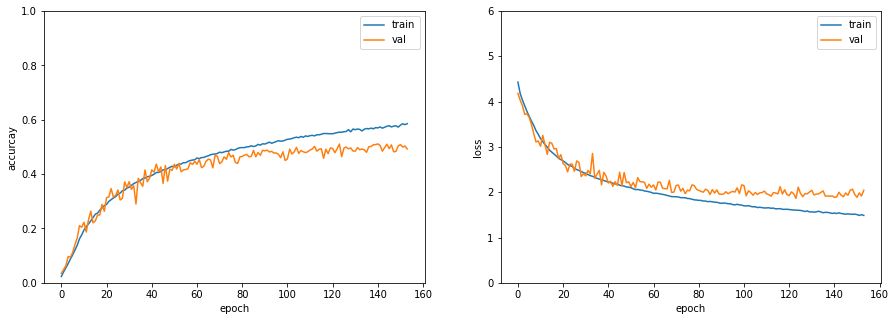

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 와... 같은 모델에서 DropOut 위치만 바꿔줬는데 성능향상에 과적합도 약해졌다
- 왜 이런 차이가 날까??? 뭐라 검색해야 관련된 내용을 찾을 수 있을까?? 드랍아웃 위치??

## 연속 Conv에서 하나짜리 Conv로 변경(0.5325) -model1

- 위의 DropOut 위치 변경(0.5269) 모델을 가져와 Conv가 2개씩 있던 것을 하나로 줄여보았다
- Conv층이 하나일때랑 2개 연속일때를 비교해보자 학습을 시켰다

In [ ]:
# Con1volution - Batch Normalization - Activation - Dropout - Pooling
model1 = Sequential()
model1.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(128, (3, 3),padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(128, (3, 3),padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(128, (3, 3),padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Conv2D(128, (3, 3),padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2)))
model1.add(layers.Dropout(0.2))

model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 9s 6ms/step - loss: 4.2733 - accuracy: 0.0411 - val_loss: 3.9656 - val_accuracy: 0.0735
Epoch 2/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.9159 - accuracy: 0.0812 - val_loss: 3.7036 - val_accuracy: 0.1130
Epoch 3/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.6888 - accuracy: 0.1090 - val_loss: 3.4396 - val_accuracy: 0.1489
Epoch 4/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.4833 - accuracy: 0.1424 - val_loss: 3.3291 - val_accuracy: 0.1745
Epoch 5/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.3312 - accuracy: 0.1701 - val_loss: 3.3571 - val_accuracy: 0.1742
Epoch 6/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.1883 - accuracy: 0.2001 - val_loss: 3.6532 - val_accuracy: 0.1458
Epoch 7/200
1250/1250 [==============================] - 7s 6ms/step - loss: 3.0577 - accuracy: 0.2263 - val_loss: 3.0469 - val_ac

In [ ]:
model1.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7850 - accuracy: 0.5325


[1.7850075960159302, 0.5325000286102295]

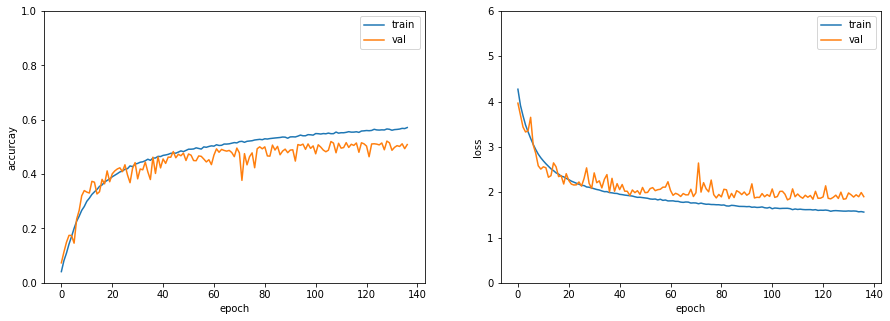

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 기존과 성능은 거의 동일. val_loss,acc가 전보다는 조금 더 튄다 => 그래프가 저렇게 요동치며 가끔씩 툭 튀는 아웃라이어가 있을 경우 안전성이 떨어진다고 보면 되나?

## Activation - Batch Normalization으로 순서변경(0.5362)

In [ ]:
# Convolution - Activation - Batch Normalization - Dropout - Pooling
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same',activation='relu', input_shape=[32,32,3]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 18s 7ms/step - loss: 4.2490 - accuracy: 0.0511 - val_loss: 4.2294 - val_accuracy: 0.0556
Epoch 2/200
1250/1250 [==============================] - 8s 7ms/step - loss: 3.8389 - accuracy: 0.0982 - val_loss: 3.6960 - val_accuracy: 0.1243
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6123 - accuracy: 0.1354 - val_loss: 3.2880 - val_accuracy: 0.1914
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.4121 - accuracy: 0.1700 - val_loss: 3.1321 - val_accuracy: 0.2189
Epoch 5/200
1250/1250 [==============================] - 8s 6ms/step - loss: 3.2393 - accuracy: 0.1998 - val_loss: 3.4399 - val_accuracy: 0.1673
Epoch 6/200
1250/1250 [==============================] - 8s 6ms/step - loss: 3.0909 - accuracy: 0.2229 - val_loss: 2.8518 - val_accuracy: 0.2689
Epoch 7/200
1250/1250 [==============================] - 8s 6ms/step - loss: 2.9781 - accuracy: 0.2460 - val_loss: 3.0683 - val

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7533 - accuracy: 0.5362


[1.7532763481140137, 0.5361999869346619]

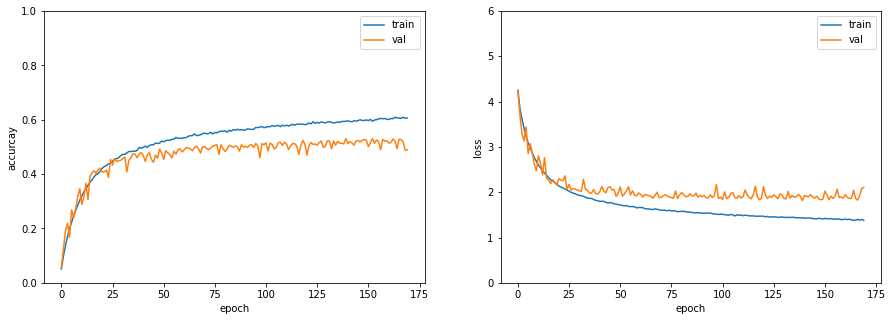

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 음...큰 변화는 없음.

# 2022.11.11(금)

## VGG 구현

![s](https://miro.medium.com/max/1400/1*Dsdd_ElH2V-CyrqnGZWdtw.png)


- VGG는 224x224 이미지 기준이므로 32x32 이미지에 안맞을 수도 있다

  => 데이터에 비해 모델의 복잡도가 높으므로 과적합될 가능성이 높음. 

### VGG16(0.4216)

In [ ]:
# VGG16
model = Sequential()
model.add(layers.Conv2D(32, (3, 3),padding='same',activation='relu', input_shape=[32,32,3]))
model.add(layers.Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(256, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 52s 12ms/step - loss: 4.4694 - accuracy: 0.0226 - val_loss: 4.3164 - val_accuracy: 0.0362
Epoch 2/200
1250/1250 [==============================] - 15s 12ms/step - loss: 4.2602 - accuracy: 0.0365 - val_loss: 4.1250 - val_accuracy: 0.0433
Epoch 3/200
1250/1250 [==============================] - 15s 12ms/step - loss: 4.1337 - accuracy: 0.0449 - val_loss: 4.1564 - val_accuracy: 0.0495
Epoch 4/200
1250/1250 [==============================] - 15s 12ms/step - loss: 4.0461 - accuracy: 0.0568 - val_loss: 4.1104 - val_accuracy: 0.0485
Epoch 5/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.9420 - accuracy: 0.0676 - val_loss: 3.7726 - val_accuracy: 0.0808
Epoch 6/200
1250/1250 [==============================] - 15s 12ms/step - loss: 3.8374 - accuracy: 0.0764 - val_loss: 3.7184 - val_accuracy: 0.0896
Epoch 7/200
1250/1250 [==============================] - 14s 12ms/step - loss: 3.7517 - accuracy: 0.0880 - val_loss: 3

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.3503 - accuracy: 0.4216


[2.3503146171569824, 0.42160001397132874]

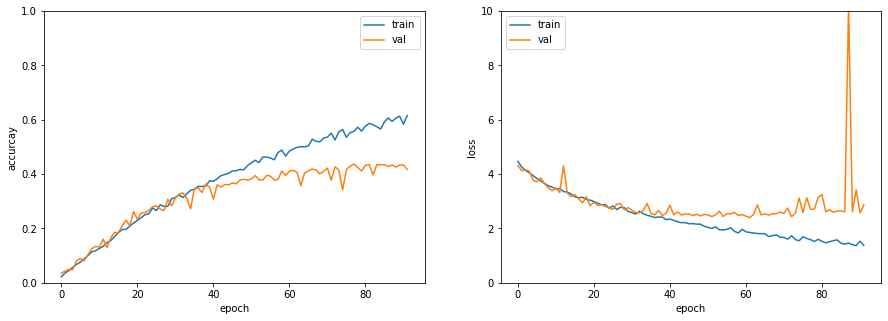

In [ ]:
show_loss_acc(history, (0,1.0),(0,10))

- 논문 그대로 하기엔 채널,노드수가 많다 생각되서 좀 낮췄다
- 성능이 전보단 좋진 않으나 과적합도 심하지 않고 그래프의 요동치는게 줄었다.
- 그래프가 요동치는건 어떤걸 의미할까


### VGG19

In [ ]:
# VGG16
model = Sequential()
model.add(layers.Conv2D(64, (3, 3),padding='same',activation='relu', input_shape=[32,32,3]))
model.add(layers.Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3),padding='same',activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 23s 10ms/step - loss: 4.4377 - accuracy: 0.0211 - val_loss: 4.4614 - val_accuracy: 0.0163
Epoch 2/200
1250/1250 [==============================] - 11s 9ms/step - loss: 4.2899 - accuracy: 0.0275 - val_loss: 4.1854 - val_accuracy: 0.0349
Epoch 3/200
1250/1250 [==============================] - 11s 9ms/step - loss: 4.2147 - accuracy: 0.0355 - val_loss: 4.2800 - val_accuracy: 0.0409
Epoch 4/200
1250/1250 [==============================] - 11s 9ms/step - loss: 4.1608 - accuracy: 0.0404 - val_loss: 4.1698 - val_accuracy: 0.0455
Epoch 5/200
1250/1250 [==============================] - 12s 9ms/step - loss: 4.0676 - accuracy: 0.0497 - val_loss: 4.0715 - val_accuracy: 0.0547
Epoch 6/200
1250/1250 [==============================] - 12s 9ms/step - loss: 4.0049 - accuracy: 0.0545 - val_loss: 3.9679 - val_accuracy: 0.0634
Epoch 7/200
1250/1250 [==============================] - 11s 9ms/step - loss: 3.9065 - accuracy: 0.0628 - val_loss: 3.8315 

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## 0.5325모델 Conv-Bn-Act 2블럭 연속(0.5374) - model2

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model2 = Sequential()
model2.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(64, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.Conv2D(128, (3, 3),padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2)))
model2.add(layers.Dropout(0.2))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 13s 9ms/step - loss: 4.4183 - accuracy: 0.0277 - val_loss: 4.5795 - val_accuracy: 0.0321
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1235 - accuracy: 0.0448 - val_loss: 3.9818 - val_accuracy: 0.0542
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9601 - accuracy: 0.0631 - val_loss: 4.0024 - val_accuracy: 0.0662
Epoch 4/200
1250/1250 [==============================] - 11s 8ms/step - loss: 3.7775 - accuracy: 0.0847 - val_loss: 3.5617 - val_accuracy: 0.1185
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.5494 - accuracy: 0.1211 - val_loss: 3.4286 - val_accuracy: 0.1462
Epoch 6/200
1250/1250 [==============================] - 11s 8ms/step - loss: 3.3324 - accuracy: 0.1565 - val_loss: 3.1252 - val_accuracy: 0.1871
Epoch 7/200
1250/1250 [==============================] - 11s 8ms/step - loss: 3.1241 - accuracy: 0.1923 - val_loss: 2.9283 -

In [ ]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.8545 - accuracy: 0.5374


[1.8544535636901855, 0.5374000072479248]

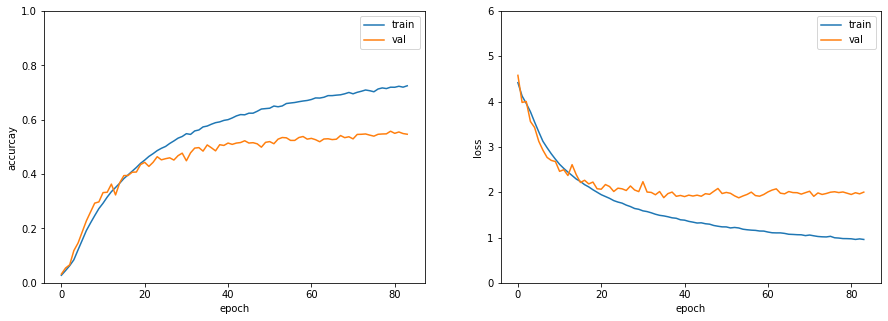

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- Conv 2개를 거치고 Dropout을 거치니 과적합이 심해졌다.

## Conv 한 블럭 제거(0.5612)

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(64, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(64, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

# model.add(layers.Conv2D(128, (3, 3),padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Conv2D(128, (3, 3),padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2)))
# model.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 20s 8ms/step - loss: 4.3883 - accuracy: 0.0329 - val_loss: 4.3255 - val_accuracy: 0.0297
Epoch 2/200
1250/1250 [==============================] - 9s 7ms/step - loss: 4.0910 - accuracy: 0.0561 - val_loss: 4.1209 - val_accuracy: 0.0576
Epoch 3/200
1250/1250 [==============================] - 9s 7ms/step - loss: 3.9148 - accuracy: 0.0763 - val_loss: 3.8060 - val_accuracy: 0.0855
Epoch 4/200
1250/1250 [==============================] - 9s 7ms/step - loss: 3.6797 - accuracy: 0.1103 - val_loss: 3.5610 - val_accuracy: 0.1389
Epoch 5/200
1250/1250 [==============================] - 9s 7ms/step - loss: 3.3882 - accuracy: 0.1589 - val_loss: 3.1102 - val_accuracy: 0.2020
Epoch 6/200
1250/1250 [==============================] - 9s 7ms/step - loss: 3.1244 - accuracy: 0.2062 - val_loss: 2.8646 - val_accuracy: 0.2560
Epoch 7/200
1250/1250 [==============================] - 9s 7ms/step - loss: 2.9233 - accuracy: 0.2482 - val_loss: 2.7381 - val_a

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.8704 - accuracy: 0.5612


[1.870421290397644, 0.5612000226974487]

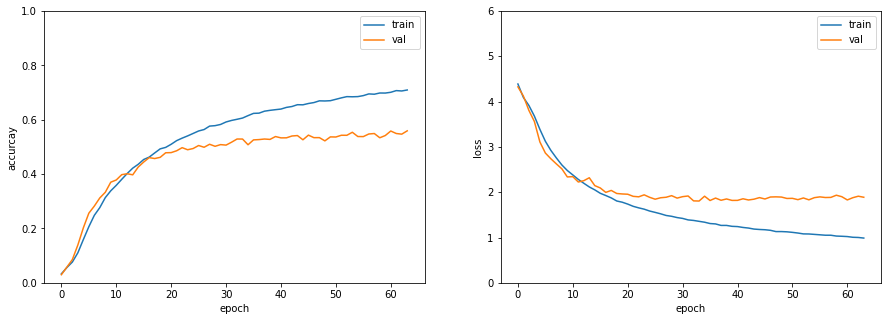

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- Conv-Bn-Act-Conv-Bn-Act-Pool-Dropout 으로 이루어진 한 블럭을 제거하고 학습
- Conv 5블럭은 과한가?? 그래프의 진동이 줄어들었다
- 여기서 채널 개수를 올려보자

# 2022.11.12(토)

## 채널 수 증가(0.5710)

- Conv 한 블럭 제거(0.5612) 모델에서 Conv의 채널을 2배로 올렸다
- 과적합이 있지만 dropout을 좀더 올리고 성능향상을 위해 피쳐수를 더 뽑는다면 성능향상이 있지 않을까??
- 먼저 채널수를 올리고 dropout을 0.3, 0.4로 올려보겠다

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(128, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

# model.add(layers.Conv2D(128, (3, 3),padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Conv2D(128, (3, 3),padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D((2)))
# model.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 12s 8ms/step - loss: 4.4890 - accuracy: 0.0215 - val_loss: 4.4004 - val_accuracy: 0.0263
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.2578 - accuracy: 0.0358 - val_loss: 4.0532 - val_accuracy: 0.0501
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1035 - accuracy: 0.0499 - val_loss: 3.9445 - val_accuracy: 0.0671
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9362 - accuracy: 0.0736 - val_loss: 3.7152 - val_accuracy: 0.1089
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.7257 - accuracy: 0.1045 - val_loss: 3.4722 - val_accuracy: 0.1418
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.4584 - accuracy: 0.1470 - val_loss: 3.2389 - val_accuracy: 0.1952
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.1723 - accuracy: 0.1963 - val_loss: 3.0042 -

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.1231 - accuracy: 0.5710


[2.1231229305267334, 0.5709999799728394]

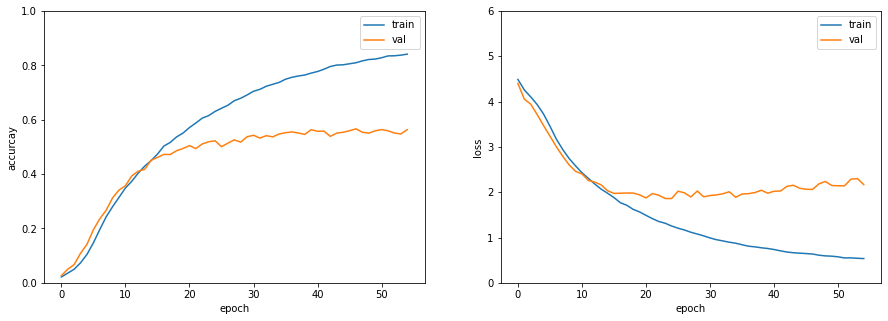

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## Dropout(0.3) (0.5633)

- 위의 채널 수 증가(0.5710) 모델에서 Dropout비율을 올려보았다

In [ ]:
# Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(128, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 12s 8ms/step - loss: 4.5335 - accuracy: 0.0184 - val_loss: 4.4441 - val_accuracy: 0.0229
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.3888 - accuracy: 0.0246 - val_loss: 4.2917 - val_accuracy: 0.0317
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.2711 - accuracy: 0.0327 - val_loss: 4.1412 - val_accuracy: 0.0418
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1572 - accuracy: 0.0466 - val_loss: 4.1621 - val_accuracy: 0.0479
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.0181 - accuracy: 0.0652 - val_loss: 3.8750 - val_accuracy: 0.0773
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.8374 - accuracy: 0.0889 - val_loss: 3.7783 - val_accuracy: 0.1014
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6653 - accuracy: 0.1155 - val_loss: 3.4206 -

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.8489 - accuracy: 0.5633


[1.8489001989364624, 0.5633000135421753]

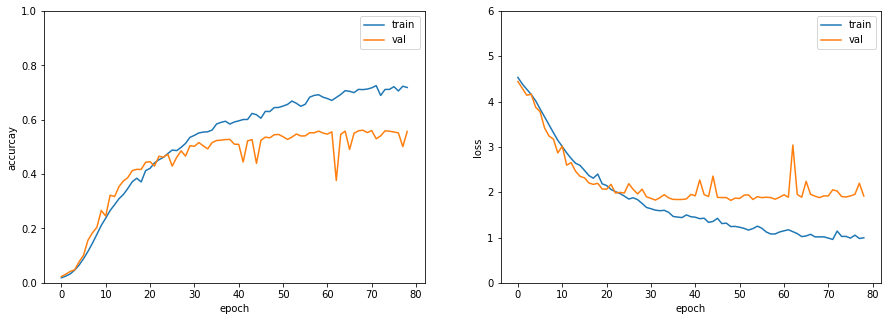

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## Dense-Dropout 한 세트 제거(0.5707)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(128, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 11s 8ms/step - loss: 4.3942 - accuracy: 0.0298 - val_loss: 4.0627 - val_accuracy: 0.0493
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1536 - accuracy: 0.0452 - val_loss: 4.0511 - val_accuracy: 0.0689
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.0455 - accuracy: 0.0611 - val_loss: 4.1482 - val_accuracy: 0.0723
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9038 - accuracy: 0.0804 - val_loss: 3.6766 - val_accuracy: 0.1144
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6804 - accuracy: 0.1124 - val_loss: 3.4993 - val_accuracy: 0.1397
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.3958 - accuracy: 0.1616 - val_loss: 3.2227 - val_accuracy: 0.1996
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.1267 - accuracy: 0.2081 - val_loss: 2.8835 -

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.5254 - accuracy: 0.5707


[2.5254337787628174, 0.5706999897956848]

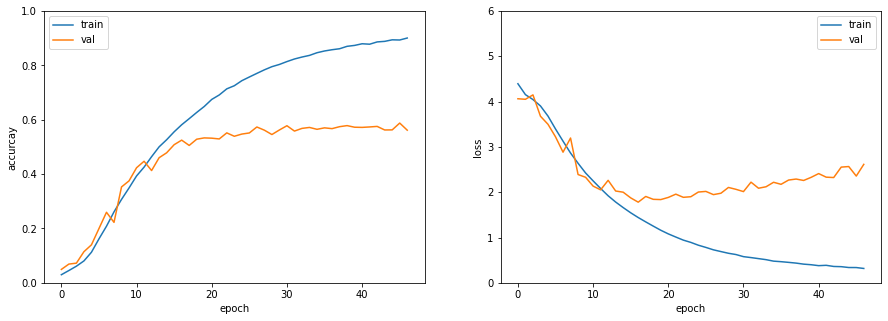

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## Dropout비율이랑 Conv 채널수 조정 (0.5878)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(128, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(128, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 12s 8ms/step - loss: 4.5576 - accuracy: 0.0170 - val_loss: 4.4317 - val_accuracy: 0.0241
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.4496 - accuracy: 0.0226 - val_loss: 4.3999 - val_accuracy: 0.0269
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.3875 - accuracy: 0.0263 - val_loss: 4.3131 - val_accuracy: 0.0336
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.3482 - accuracy: 0.0286 - val_loss: 4.1825 - val_accuracy: 0.0479
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.1964 - accuracy: 0.0461 - val_loss: 3.9196 - val_accuracy: 0.0795
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.9401 - accuracy: 0.0784 - val_loss: 3.8912 - val_accuracy: 0.0975
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.7409 - accuracy: 0.1054 - val_loss: 3.5658 -

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.0430 - accuracy: 0.5878


[2.0430238246917725, 0.5878000259399414]

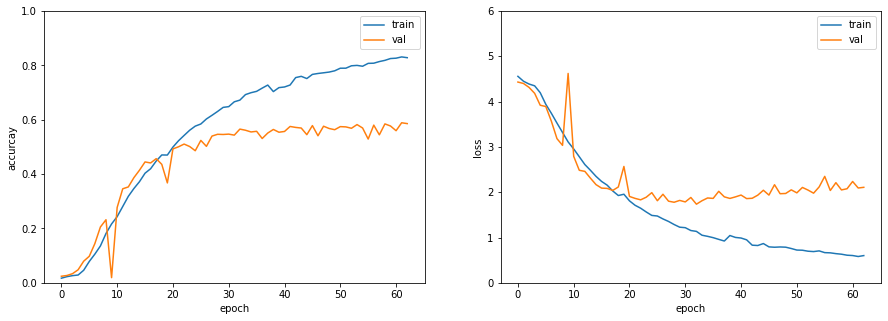

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## Dropout비율이랑 Conv 채널수 조정2 (0.5954)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 19s 14ms/step - loss: 4.5208 - accuracy: 0.0182 - val_loss: 4.2818 - val_accuracy: 0.0275
Epoch 2/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.3662 - accuracy: 0.0260 - val_loss: 4.2651 - val_accuracy: 0.0363
Epoch 3/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.3201 - accuracy: 0.0286 - val_loss: 4.1434 - val_accuracy: 0.0468
Epoch 4/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.2859 - accuracy: 0.0316 - val_loss: 4.1630 - val_accuracy: 0.0424
Epoch 5/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.2443 - accuracy: 0.0374 - val_loss: 4.1541 - val_accuracy: 0.0485
Epoch 6/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.1345 - accuracy: 0.0461 - val_loss: 3.9128 - val_accuracy: 0.0742
Epoch 7/200
1250/1250 [==============================] - 17s 14ms/step - loss: 4.0278 - accuracy: 0.0607 - val_loss: 3

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 2.2397 - accuracy: 0.5954


[2.2397236824035645, 0.5953999757766724]

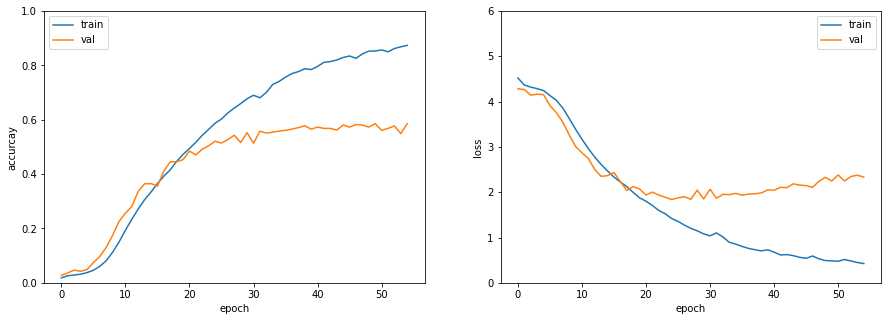

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

# 2022.11.13(일)

## Adam(learning_rate=0.0005) (0.6221)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0005) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 84s 59ms/step - loss: 4.5431 - accuracy: 0.0207 - val_loss: 4.2953 - val_accuracy: 0.0416
Epoch 2/200
1250/1250 [==============================] - 76s 61ms/step - loss: 4.3160 - accuracy: 0.0320 - val_loss: 4.2261 - val_accuracy: 0.0375
Epoch 3/200
1250/1250 [==============================] - 76s 61ms/step - loss: 4.1972 - accuracy: 0.0423 - val_loss: 4.0285 - val_accuracy: 0.0633
Epoch 4/200
1250/1250 [==============================] - 77s 61ms/step - loss: 4.0764 - accuracy: 0.0546 - val_loss: 3.9040 - val_accuracy: 0.0787
Epoch 5/200
1250/1250 [==============================] - 77s 61ms/step - loss: 3.9423 - accuracy: 0.0690 - val_loss: 3.8841 - val_accuracy: 0.0899
Epoch 6/200
1250/1250 [==============================] - 77s 61ms/step - loss: 3.7830 - accuracy: 0.0894 - val_loss: 3.3829 - val_accuracy: 0.1537
Epoch 7/200
1250/1250 [==============================] - 77s 61ms/step - loss: 3.6182 - accuracy: 0.1098 - val_loss: 3

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 2.4432 - accuracy: 0.6221


[2.4432222843170166, 0.6220999956130981]

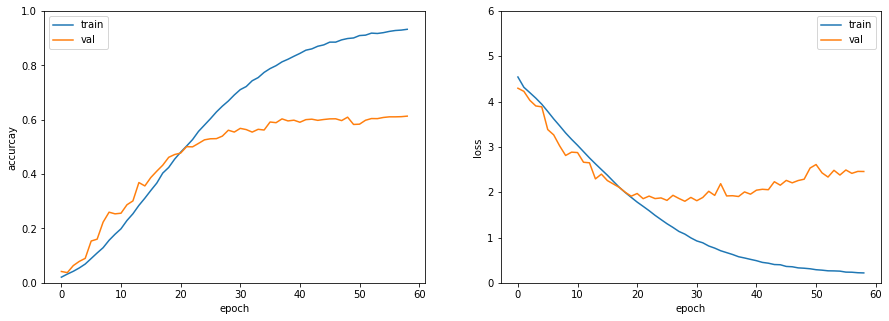

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- Adam으로 학습률 0.005주었더니 0.59 -> 0.62
- 과적합도 다시 심해짐

## Adam(learning_rate=0.0001) (0.5979)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 78s 62ms/step - loss: 4.5396 - accuracy: 0.0315 - val_loss: 4.1507 - val_accuracy: 0.0711
Epoch 2/200
1250/1250 [==============================] - 78s 62ms/step - loss: 4.1478 - accuracy: 0.0697 - val_loss: 3.9146 - val_accuracy: 0.1013
Epoch 3/200
1250/1250 [==============================] - 77s 62ms/step - loss: 3.8461 - accuracy: 0.1049 - val_loss: 3.5141 - val_accuracy: 0.1629
Epoch 4/200
1250/1250 [==============================] - 77s 62ms/step - loss: 3.5310 - accuracy: 0.1523 - val_loss: 3.1229 - val_accuracy: 0.2276
Epoch 5/200
1250/1250 [==============================] - 77s 62ms/step - loss: 3.1835 - accuracy: 0.2131 - val_loss: 2.8276 - val_accuracy: 0.2800
Epoch 6/200
1250/1250 [==============================] - 78s 63ms/step - loss: 2.8938 - accuracy: 0.2668 - val_loss: 2.5553 - val_accuracy: 0.3398
Epoch 7/200
1250/1250 [==============================] - 77s 62ms/step - loss: 2.6688 - accuracy: 0.3103 - val_loss: 2

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 2.3232 - accuracy: 0.5979


[2.3231539726257324, 0.5978999733924866]

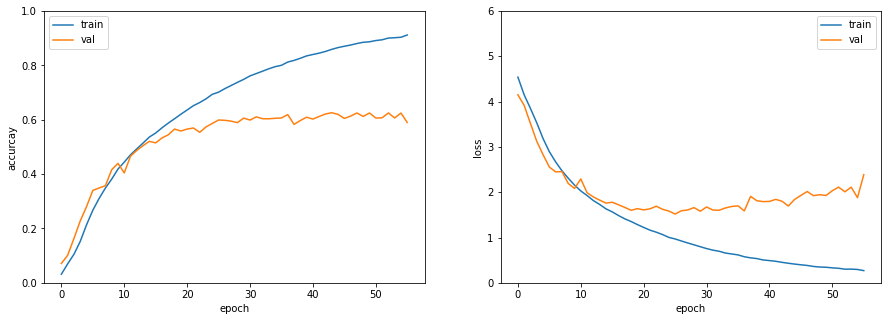

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
model3 = Sequential()
model3.add(layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3]))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(256, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.3))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.4))

model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.Conv2D(512, (3, 3),padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2)))
model3.add(layers.Dropout(0.5))

model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation='relu'))
# model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0005) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 79s 62ms/step - loss: 4.5776 - accuracy: 0.0198 - val_loss: 4.3745 - val_accuracy: 0.0379
Epoch 2/200
1250/1250 [==============================] - 77s 61ms/step - loss: 4.3442 - accuracy: 0.0312 - val_loss: 4.0781 - val_accuracy: 0.0551
Epoch 3/200
1250/1250 [==============================] - 77s 61ms/step - loss: 4.2305 - accuracy: 0.0380 - val_loss: 3.9908 - val_accuracy: 0.0657
Epoch 4/200
1250/1250 [==============================] - 77s 61ms/step - loss: 4.1541 - accuracy: 0.0449 - val_loss: 4.0482 - val_accuracy: 0.0641
Epoch 5/200
1250/1250 [==============================] - 77s 61ms/step - loss: 4.0524 - accuracy: 0.0526 - val_loss: 3.9113 - val_accuracy: 0.0839
Epoch 6/200
1250/1250 [==============================] - 77s 62ms/step - loss: 3.9168 - accuracy: 0.0672 - val_loss: 3.6037 - val_accuracy: 0.1137
Epoch 7/200
1250/1250 [==============================] - 77s 62ms/step - loss: 3.7452 - accuracy: 0.0893 - val_loss: 3

In [ ]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 2.4439 - accuracy: 0.6103


[2.443896532058716, 0.6103000044822693]

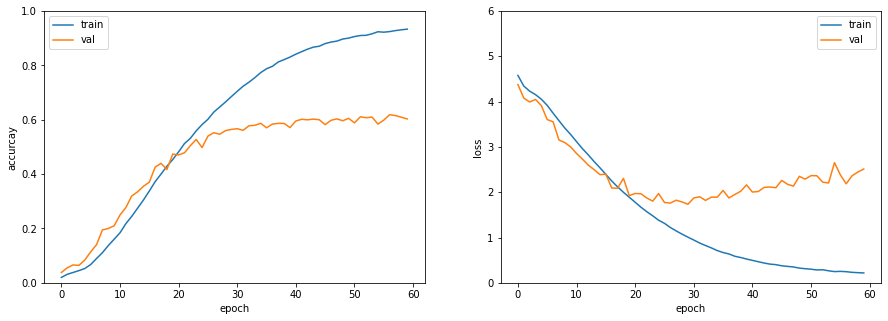

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## ResNet 18 구현

[논문구현_resnet](https://velog.io/@noooooh_042/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84resnet)

[Understanding and visualizing ResNets](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)

[ResNets for CIFAR-10](https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0)

[tensorflow Custom Model (Mini ResNet, VGGNet 구현)](https://junstar92.tistory.com/146)

[ResNet18](https://hnsuk.tistory.com/31)

The feature map sizes are {32, 16, 8} respectively with 2 convolutions for each feature map size. 

Also, the number of filters is {16, 32, 64} respectively.

In [ ]:
# 제대로 만든게 맞나...?

input_shape=[32,32,3]

input = layers.Input(input_shape)
conv1 = layers.Conv2D(64,3,padding='same')(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
shortcut = x # 32,32,16

# layer1
conv2_1 = layers.Conv2D(64,3,padding='same')(x)
x = layers.BatchNormalization()(conv2_1)
x = layers.Activation('relu')(x)
conv2_2 = layers.Conv2D(64,3,padding='same')(x)
x = layers.BatchNormalization()(conv2_2)
x = layers.Add()([shortcut, x])
x = layers.Activation('relu')(x)

# layer2
conv3_1 = layers.Conv2D(128,3,strides=2,padding='valid')(x) # down-sampling, 16,16,32
x = layers.BatchNormalization()(conv3_1)
x = layers.Activation('relu')(x)
conv3_2 = layers.Conv2D(128,3,padding='same')(x)
x = layers.BatchNormalization()(conv3_2)
x = layers.Activation('relu')(x)
conv3_3 = layers.Conv2D(128,3,padding='same')(x)
x = layers.BatchNormalization()(conv3_3)
x = layers.Add()([conv3_1, x])
x = layers.Activation('relu')(x)

# layer3
conv4_1 = layers.Conv2D(256,3,strides=2,padding='valid')(x) # down-sampling, 16,16,32
x = layers.BatchNormalization()(conv4_1)
x = layers.Activation('relu')(x)
conv4_2 = layers.Conv2D(256,3,padding='same')(x)
x = layers.BatchNormalization()(conv4_2)
x = layers.Activation('relu')(x)
conv4_3 = layers.Conv2D(256,3,padding='same')(x)
x = layers.BatchNormalization()(conv4_3)
x = layers.Add()([conv4_1, x])
x = layers.Activation('relu')(x)

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(gap)
output= layers.Dense(100, activation='relu')(flatten)

resnet18 = keras.Model(inputs=input, outputs=output)
resnet18.summary()

## shotcut connection 적용 - Adam(learning_rate=0.0005) (0.5585)

- Adam(learning_rate=0.0005) (0.6221)의 모델을 ResNet의 주요 기법인 shotcut connection을 사용해 변형시켜보았다
- 일단 풀링과 드랍아웃, GlobalAveragePooling은 한번 뺀 상태에서 돌려보니 전혀 학습안됨. 

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling

input = layers.Input(input_shape)
conv1 = layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(x)
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(dropout)

model_by_resnet = keras.Model(inputs=input, outputs=output)

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0005) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 81s 64ms/step - loss: 4.5770 - accuracy: 0.0216 - val_loss: 4.3153 - val_accuracy: 0.0430
Epoch 2/200
1250/1250 [==============================] - 78s 63ms/step - loss: 4.2893 - accuracy: 0.0457 - val_loss: 4.1390 - val_accuracy: 0.0709
Epoch 3/200
1250/1250 [==============================] - 78s 62ms/step - loss: 4.1104 - accuracy: 0.0696 - val_loss: 3.8668 - val_accuracy: 0.1063
Epoch 4/200
1250/1250 [==============================] - 78s 63ms/step - loss: 3.9135 - accuracy: 0.0974 - val_loss: 3.7947 - val_accuracy: 0.1161
Epoch 5/200
1250/1250 [==============================] - 78s 62ms/step - loss: 3.7387 - accuracy: 0.1246 - val_loss: 3.5489 - val_accuracy: 0.1665
Epoch 6/200
1250/1250 [==============================] - 78s 62ms/step - loss: 3.5538 - accuracy: 0.1520 - val_loss: 3.3456 - val_accuracy: 0.1964
Epoch 7/200
1250/1250 [==============================] - 78s 62ms/step - loss: 3.4054 - accuracy: 0.1804 - val_loss: 3

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 1.8837 - accuracy: 0.5585


[1.883676528930664, 0.5584999918937683]

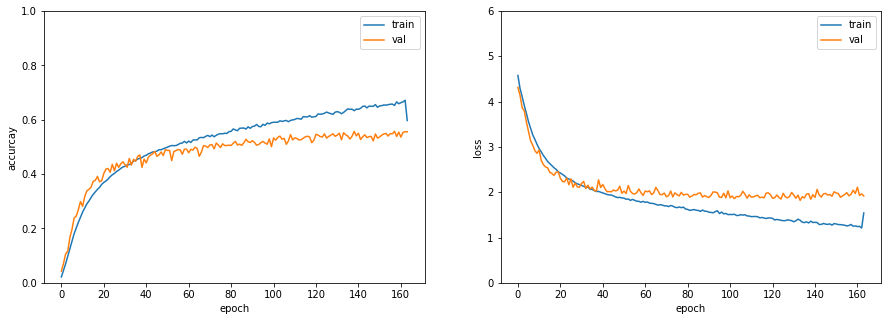

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 성능이 잘 나오는것 같진 않다... 옵티마이저의 기본 학습률일때도 학습이 잘 안되는 경우가 있음 => 모델에 맞는 학습률이 다 다름. 다 시도해봐야 적합한 값을 고를 수 있다

## shotcut connection 적용 - Adam(learning_rate=0.0001) (0.6289)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling

input = layers.Input(input_shape)
conv1 = layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(x)
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(dropout)

model_by_resnet = keras.Model(inputs=input, outputs=output)

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 80s 63ms/step - loss: 4.6776 - accuracy: 0.0202 - val_loss: 4.3557 - val_accuracy: 0.0466
Epoch 2/200
1250/1250 [==============================] - 79s 63ms/step - loss: 4.3200 - accuracy: 0.0491 - val_loss: 4.0051 - val_accuracy: 0.0911
Epoch 3/200
1250/1250 [==============================] - 79s 63ms/step - loss: 4.0291 - accuracy: 0.0858 - val_loss: 3.6505 - val_accuracy: 0.1406
Epoch 4/200
1250/1250 [==============================] - 78s 63ms/step - loss: 3.7608 - accuracy: 0.1229 - val_loss: 3.3950 - val_accuracy: 0.1896
Epoch 5/200
1250/1250 [==============================] - 78s 63ms/step - loss: 3.4788 - accuracy: 0.1696 - val_loss: 3.2691 - val_accuracy: 0.2087
Epoch 6/200
1250/1250 [==============================] - 79s 63ms/step - loss: 3.1891 - accuracy: 0.2183 - val_loss: 2.9175 - val_accuracy: 0.2802
Epoch 7/200
1250/1250 [==============================] - 79s 63ms/step - loss: 2.9054 - accuracy: 0.2733 - val_loss: 2

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 1.7919 - accuracy: 0.6289


[1.7918838262557983, 0.6288999915122986]

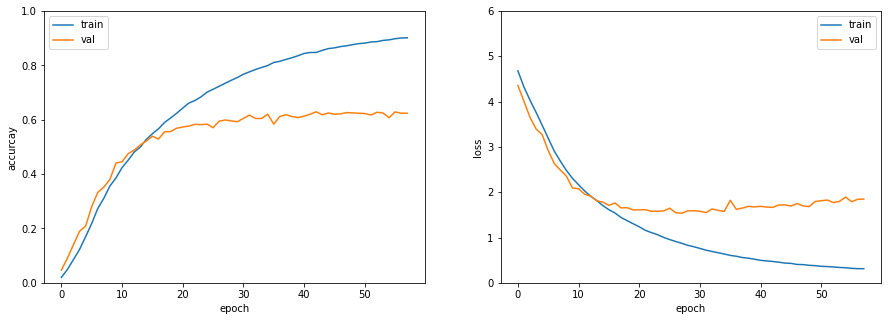

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## 함수로 ResNet 블럭 만들어서 사용

In [ ]:
def identity_block(input, channels, filter_size): # input과 output의 shape가 같을때 사용.
    shortcut = input
    x = layers.Conv2D(channels,filter_size,padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    concat = layers.Add()([shortcut,x])
    x = layers.Activation('relu')(concat)

    return x

def conv_block(input, channels, filter_size): # input과 output의 shape가 다를 경우. 
    shortcut = layers.Conv2D(channels,filter_size,padding='same')(input)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(channels,filter_size,padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    concat = layers.Add()([shortcut,x])
    x = layers.Activation('relu')(concat)

    return x

### 스테이지 3개(conv_block - identity_block) 필터64, 128, 256 (0.6141)

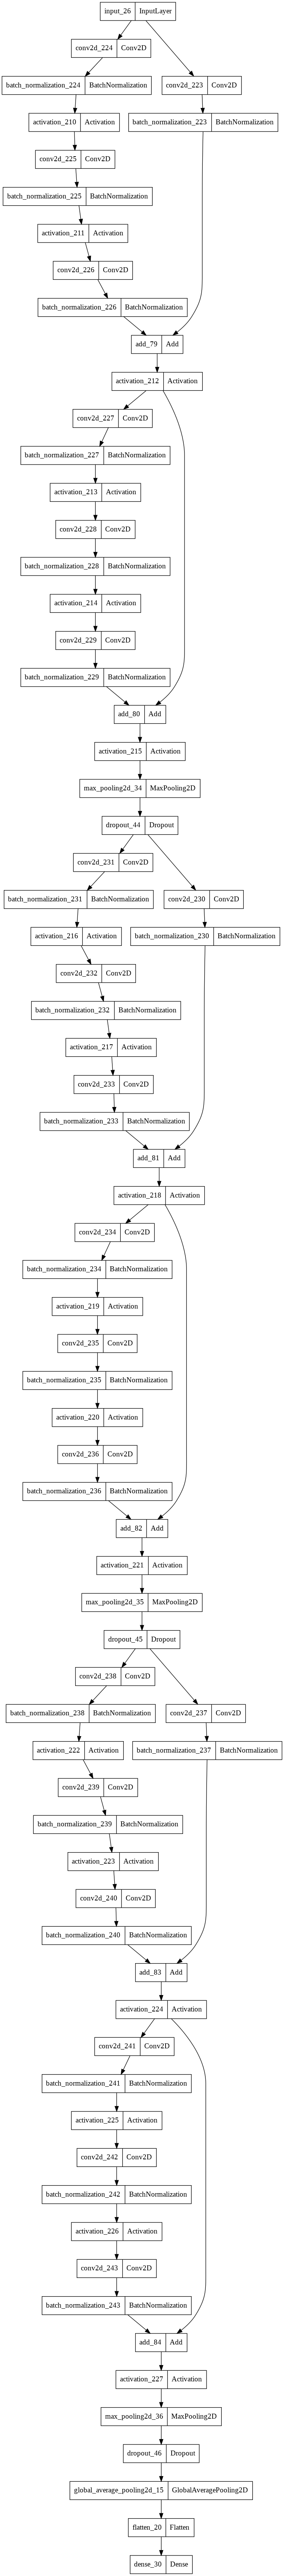

In [ ]:
# 64,128,256
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 16,16,64

x = conv_block(x,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 8,8,64

x = conv_block(x,256,3)
x = identity_block(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(gap)
output = layers.Dense(100,activation='softmax')(flatten)

custom_resnet = keras.Model(inputs=input, outputs=output)
plot_model(custom_resnet)

In [ ]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 48s 36ms/step - loss: 3.8091 - accuracy: 0.1188 - val_loss: 3.5753 - val_accuracy: 0.1447
Epoch 2/200
1250/1250 [==============================] - 44s 35ms/step - loss: 2.8438 - accuracy: 0.2774 - val_loss: 2.8402 - val_accuracy: 0.3208
Epoch 3/200
1250/1250 [==============================] - 43s 35ms/step - loss: 2.3025 - accuracy: 0.3872 - val_loss: 2.6712 - val_accuracy: 0.3273
Epoch 4/200
1250/1250 [==============================] - 43s 34ms/step - loss: 1.9555 - accuracy: 0.4649 - val_loss: 2.0307 - val_accuracy: 0.4525
Epoch 5/200
1250/1250 [==============================] - 45s 36ms/step - loss: 1.7079 - accuracy: 0.5228 - val_loss: 1.8837 - val_accuracy: 0.4834
Epoch 6/200
1250/1250 [==============================] - 44s 35ms/step - loss: 1.4967 - accuracy: 0.5725 - val_loss: 1.8686 - val_accuracy: 0.4942
Epoch 7/200
1250/1250 [==============================] - 47s 37ms/step - loss: 1.3238 - accuracy: 0.6172 - val_loss: 1

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.4417 - accuracy: 0.6141


[1.4417246580123901, 0.6140999794006348]

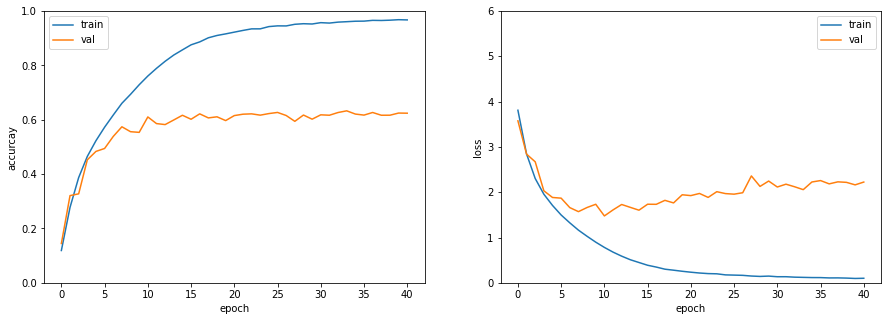

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 스테이지 3개(conv_block - identity_block) 필터 128, 256, 512 (0.6056)

In [ ]:
# 128,256,512
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 16,16,64

x = conv_block(x,256,3)
x = identity_block(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 8,8,64

x = conv_block(x,512,3)
x = identity_block(x,512,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(gap)
output = layers.Dense(100,activation='softmax')(flatten)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 117s 91ms/step - loss: 3.9627 - accuracy: 0.1086 - val_loss: 3.6751 - val_accuracy: 0.1474
Epoch 2/200
1250/1250 [==============================] - 114s 91ms/step - loss: 2.9010 - accuracy: 0.2719 - val_loss: 2.7582 - val_accuracy: 0.2991
Epoch 3/200
1250/1250 [==============================] - 113s 91ms/step - loss: 2.3056 - accuracy: 0.3912 - val_loss: 2.8272 - val_accuracy: 0.3372
Epoch 4/200
1250/1250 [==============================] - 114s 91ms/step - loss: 1.9226 - accuracy: 0.4751 - val_loss: 2.0392 - val_accuracy: 0.4546
Epoch 5/200
1250/1250 [==============================] - 114s 91ms/step - loss: 1.6350 - accuracy: 0.5428 - val_loss: 1.8156 - val_accuracy: 0.5069
Epoch 6/200
1250/1250 [==============================] - 114s 91ms/step - loss: 1.3914 - accuracy: 0.6054 - val_loss: 1.7162 - val_accuracy: 0.5284
Epoch 7/200
1250/1250 [==============================] - 113s 91ms/step - loss: 1.1791 - accuracy: 0.6573 - val_

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 8s 27ms/step - loss: 1.4836 - accuracy: 0.6056


[1.483629822731018, 0.6055999994277954]

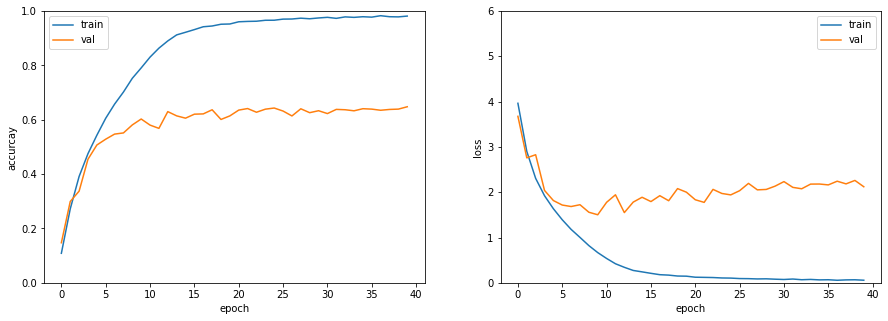

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### Dense 층 추가 (0.5802)

In [ ]:
# 64,128,256
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 16,16,64

x = conv_block(x,256,3)
x = identity_block(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 8,8,64

x = conv_block(x,512,3)
x = identity_block(x,512,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(gap)
########## Dense-Dropout 추가 #########################
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
#######################################################
output = layers.Dense(100,activation='softmax')(dropout)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 116s 91ms/step - loss: 4.3633 - accuracy: 0.0376 - val_loss: 4.2156 - val_accuracy: 0.0505
Epoch 2/200
1250/1250 [==============================] - 113s 90ms/step - loss: 4.0166 - accuracy: 0.0710 - val_loss: 5.6994 - val_accuracy: 0.0488
Epoch 3/200
1250/1250 [==============================] - 113s 90ms/step - loss: 3.7565 - accuracy: 0.1054 - val_loss: 3.6173 - val_accuracy: 0.1398
Epoch 4/200
1250/1250 [==============================] - 113s 90ms/step - loss: 3.4956 - accuracy: 0.1451 - val_loss: 3.1280 - val_accuracy: 0.2136
Epoch 5/200
1250/1250 [==============================] - 113s 90ms/step - loss: 3.2670 - accuracy: 0.1825 - val_loss: 2.9154 - val_accuracy: 0.2520
Epoch 6/200
1250/1250 [==============================] - 113s 91ms/step - loss: 3.0274 - accuracy: 0.2241 - val_loss: 2.7333 - val_accuracy: 0.2832
Epoch 7/200
1250/1250 [==============================] - 113s 90ms/step - loss: 2.8330 - accuracy: 0.2638 - val_

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 8s 27ms/step - loss: 1.5502 - accuracy: 0.5802


[1.5502288341522217, 0.5802000164985657]

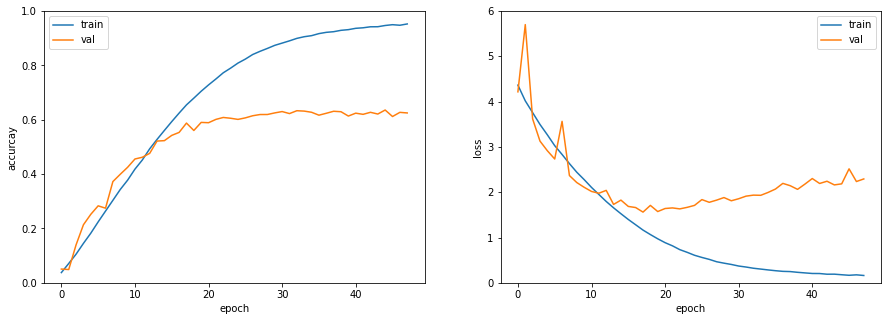

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 과적합에 대한 해결방법 없이 그냥 Dense만 넣으면 성능향상엔 도움되지 않음
- 그럼 Dense층 뒤에 BatchNormalization을 넣어주면??

# 2022.11.14(월)

## Dense층 뒤에 BatchNormalization 추가 (0.6237)

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling
input_shape = [32,32,3]

input = layers.Input(input_shape)
conv1 = layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

# gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(x)
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
#############  BatchNormalization 추가 ##################
bn = layers.BatchNormalization()(dropout)
output = layers.Dense(100,activation='softmax')(bn)

model_by_resnet = keras.Model(inputs=input, outputs=output)

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001) # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 78s 62ms/step - loss: 4.9148 - accuracy: 0.0182 - val_loss: 4.3321 - val_accuracy: 0.0501
Epoch 2/200
1250/1250 [==============================] - 76s 61ms/step - loss: 4.4835 - accuracy: 0.0410 - val_loss: 4.1588 - val_accuracy: 0.0555
Epoch 3/200
1250/1250 [==============================] - 77s 62ms/step - loss: 4.2434 - accuracy: 0.0567 - val_loss: 4.0327 - val_accuracy: 0.0749
Epoch 4/200
1250/1250 [==============================] - 76s 61ms/step - loss: 4.0814 - accuracy: 0.0724 - val_loss: 3.7975 - val_accuracy: 0.1151
Epoch 5/200
1250/1250 [==============================] - 76s 61ms/step - loss: 3.8934 - accuracy: 0.0956 - val_loss: 3.6832 - val_accuracy: 0.1324
Epoch 6/200
1250/1250 [==============================] - 76s 61ms/step - loss: 3.7534 - accuracy: 0.1129 - val_loss: 3.4983 - val_accuracy: 0.1693
Epoch 7/200
1250/1250 [==============================] - 76s 61ms/step - loss: 3.5432 - accuracy: 0.1469 - val_loss: 3

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 6s 18ms/step - loss: 1.7285 - accuracy: 0.6237


[1.7285226583480835, 0.6237000226974487]

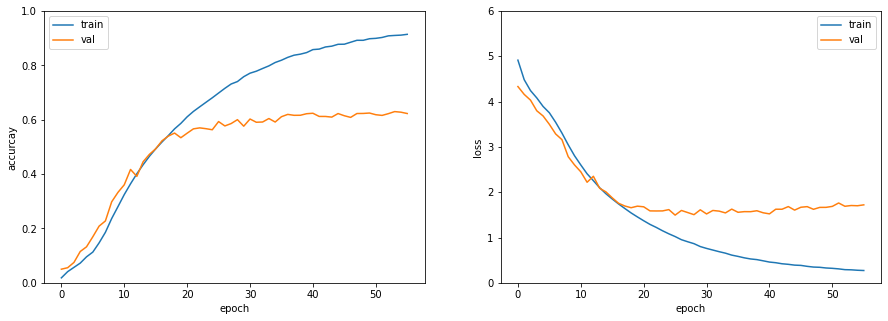

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 흠... 큰 변화는 없었다...옵티마이저를 여러개 바꿔서 써보자
- RMSProp

## 성재 피드백 참고

[성재] [오전 11:07] 봉학아

[성재] [오전 11:07] 지금 하고있는거 봤는데

[성재] [오전 11:07] 접근은 괜찮은것같음

[성재] [오전 11:08] 근데

[성재] [오전 11:08] 항상 그런게 있음

[성재] [오전 11:08] 이미지 크기랑 채널 사이즈 필터 사이즈같은건

[성재] [오전 11:08] 비슷하게 흘러가야 성능이 좋아짐

[성재] [오전 11:08] 저거 필터 줄여봐

[성재] [오전 11:08] 8, 16부터 테스트 해보셈

[성재] [오전 11:08] 그래서 저걸 함수로 묶어서

[성재] [오전 11:08] filter 매개변수 넘기고

[성재] [오전 11:08] 레이어 깊어질수록

[성재] [오전 11:08] filter * 2, filter * 4 주고

[성재] [오전 11:08] 8, 16, 32 하나씩 넣어가면서

[성재] [오전 11:08] 성능 변화 봐보셈

[성재] [오전 11:09] 그리고 flatten 대신 gap도 써보고

[성재] [오전 11:09] fc layer는 줄이면 줄일수록

[성재] [오전 11:09] 편향 분산이 작아짐

[성재] [오전 11:09] 저게 좋은게 아니라

[성재] [오전 11:09] 데이터 정규화는 어떻게 했는지

[성재] [오전 11:09] augmentation은 했는지

[성재] [오전 11:09] 이런것도 다 체크하고

[성재] [오전 11:10] 분류 모델 성능 개선 방법 다 찾아가면서 계속 해봐


### 필터 줄이기 - 8,16,32,64 (0.3291)

- 근데 항상 그런게 있음
- 이미지 크기랑 채널 사이즈 필터 사이즈같은건 비슷하게 흘러가야 성능이 좋아짐
- 저거 필터 줄여봐 8, 16부터 테스트 해보셈
---
- 피드백 참고해서 필터수부터 줄였다.
- 기존에는 블럭 4개당 256, 512, 512, 512 이렇게 필터수를 높게 주었다.
- 이렇게 많이 가져가도 성능은 0.6대가 나오긴 했지만 과적합은 여전했다
- 그리고 성능이 좋게 나와서 이런 필터수를 주긴 했으나 이미지가 32x32로 이렇게 작은데 필터수를 이렇게 주는게 맞나 하는 생각이 계속 있었다

In [ ]:
input_shape = [32,32,3]

input = layers.Input(input_shape)
conv1 = layers.Conv2D(8, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(8, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

# gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(x)
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(dropout)

model_by_resnet = keras.Model(inputs=input, outputs=output)
# model_by_resnet.summary()

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 12s 9ms/step - loss: 4.4216 - accuracy: 0.0338 - val_loss: 4.1073 - val_accuracy: 0.0625
Epoch 2/200
1250/1250 [==============================] - 10s 8ms/step - loss: 4.0449 - accuracy: 0.0719 - val_loss: 3.9424 - val_accuracy: 0.0828
Epoch 3/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.8637 - accuracy: 0.0979 - val_loss: 3.8060 - val_accuracy: 0.1068
Epoch 4/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.7699 - accuracy: 0.1128 - val_loss: 3.5937 - val_accuracy: 0.1456
Epoch 5/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6955 - accuracy: 0.1256 - val_loss: 3.5821 - val_accuracy: 0.1450
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6355 - accuracy: 0.1333 - val_loss: 3.4027 - val_accuracy: 0.1803
Epoch 7/200
1250/1250 [==============================] - 10s 8ms/step - loss: 3.6012 - accuracy: 0.1401 - val_loss: 3.3939 -

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.6162 - accuracy: 0.3291


[2.6162219047546387, 0.32910001277923584]

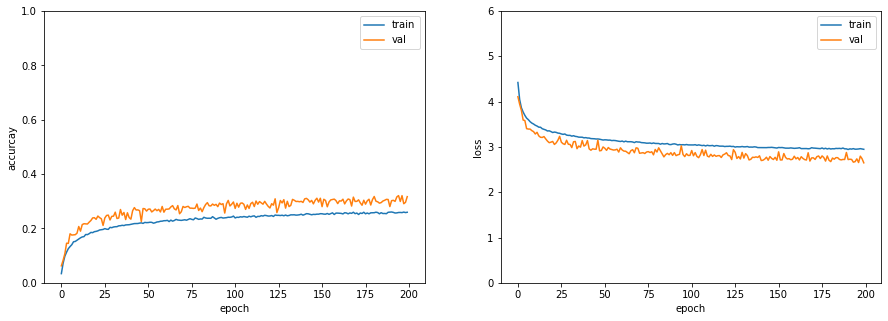

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 성능은 0.32로 낮지만 EarlyStopping이 동작하지 않았다는 점에서 더 오를 가능성이 있음
- 과적합도 없다고 봐도 되지않나…? 그동안 val_acc가 acc보다 높은건 학습시 초반에서나 그랬는데 쭉 그렇게 나오면 epoch을 더 늘리고 학습시키면 어떻게 나올까???
- 그리고 앞에서 필터수를 많이 준것과 비교되는 점 중 하나는 학습시간
- 필터수가 많을수록 그만큼 연산이 오래걸리는 건 당연하다. 
- 앞의 필터수가 많은 모델들(256,512)은 2~3시간씩 걸렸으나 16,32 로 낮추니 30분으로 줄었다
- 앞으로 필터수를 정할 때는 이미지에 맞게 혹은 조금 더 작게 주고 시작하자

### Epoch 늘려서 학습 (0.3215)

- 바로 위의 필터 줄이기 - 8,16,32,64 (0.3291) 모델을 학습하는데 EarlyStopping이 동작하지 않고 200epoch 모두 돌아갔다
- 더 학습될 여지가 있다고 생각되어 epoch을 400으로 늘리고 학습시켜보고 성능의 향상이 있는지 확인해보려 한다

In [ ]:
input_shape = [32,32,3]

input = layers.Input(input_shape)
conv1 = layers.Conv2D(8, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(8, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

# gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(x)
dense = layers.Dense(512,activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(dropout)

model_by_resnet = keras.Model(inputs=input, outputs=output)
# model_by_resnet.summary()

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

Epoch 1/400
1250/1250 [==============================] - 11s 8ms/step - loss: 4.4386 - accuracy: 0.0369 - val_loss: 4.1180 - val_accuracy: 0.0676
Epoch 2/400
1250/1250 [==============================] - 9s 7ms/step - loss: 4.0403 - accuracy: 0.0732 - val_loss: 3.9098 - val_accuracy: 0.0969
Epoch 3/400
1250/1250 [==============================] - 10s 8ms/step - loss: 3.8925 - accuracy: 0.0982 - val_loss: 3.7319 - val_accuracy: 0.1282
Epoch 4/400
1250/1250 [==============================] - 9s 8ms/step - loss: 3.7804 - accuracy: 0.1122 - val_loss: 3.8313 - val_accuracy: 0.1139
Epoch 5/400
1250/1250 [==============================] - 9s 8ms/step - loss: 3.7012 - accuracy: 0.1233 - val_loss: 3.5403 - val_accuracy: 0.1544
Epoch 6/400
1250/1250 [==============================] - 9s 7ms/step - loss: 3.6477 - accuracy: 0.1336 - val_loss: 3.4606 - val_accuracy: 0.1669
Epoch 7/400
1250/1250 [==============================] - 9s 8ms/step - loss: 3.5977 - accuracy: 0.1407 - val_loss: 3.4517 - val_

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6410 - accuracy: 0.3215


[2.6409878730773926, 0.3215000033378601]

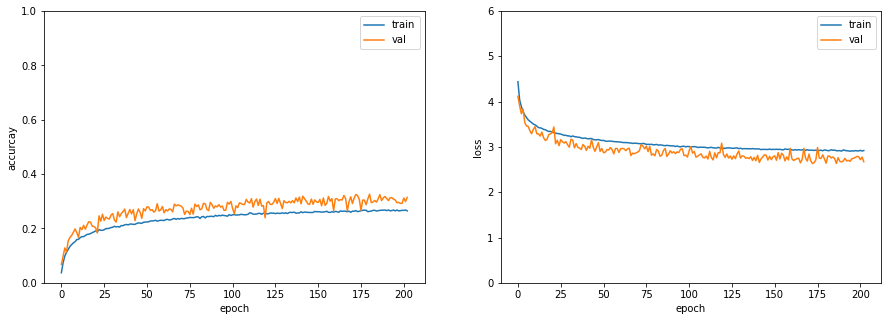

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 흠.... 오르진 않네...

### flatten 대신 gap 사용 / Dense도 제거 / Dropout 비율 조정 (0.4015)
- 필터수가 적기에 0.3, 0.3, 0.4, 0.4는 과하다 생각되어 0.2, 0.2, 0.2, 0.2로 낮춤
- Flatten 대신 GlobalAveragePooling 을 사용함
- Dense와 Dropout 한 세트도 제거

In [ ]:
input_shape = [32,32,3]

input = layers.Input(input_shape)
conv1 = layers.Conv2D(8, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(8, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.2)(x) # 0.3 -> 0.2

conv2 = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.2)(x)  # 0.3 -> 0.2

conv3 = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.2)(x) # 0.4 -> 0.2

conv4 = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.2)(x)  # 0.4 -> 0.2

# flatten 대신 gap 사용. Dense도 제거
gap = layers.GlobalAveragePooling2D()(x)
# flatten = layers.Flatten()(x)
# dense = layers.Dense(512,activation='relu')(flatten)
# dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(gap)

model_by_resnet = keras.Model(inputs=input, outputs=output)
# model_by_resnet.summary()

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

Epoch 1/400
1250/1250 [==============================] - 10s 7ms/step - loss: 4.0515 - accuracy: 0.0786 - val_loss: 3.9642 - val_accuracy: 0.0934
Epoch 2/400
1250/1250 [==============================] - 10s 8ms/step - loss: 3.5580 - accuracy: 0.1483 - val_loss: 3.6396 - val_accuracy: 0.1532
Epoch 3/400
1250/1250 [==============================] - 9s 7ms/step - loss: 3.3306 - accuracy: 0.1879 - val_loss: 3.2743 - val_accuracy: 0.2094
Epoch 4/400
1250/1250 [==============================] - 9s 7ms/step - loss: 3.1890 - accuracy: 0.2145 - val_loss: 3.1383 - val_accuracy: 0.2304
Epoch 5/400
1250/1250 [==============================] - 10s 8ms/step - loss: 3.0783 - accuracy: 0.2339 - val_loss: 2.9967 - val_accuracy: 0.2476
Epoch 6/400
1250/1250 [==============================] - 9s 7ms/step - loss: 2.9830 - accuracy: 0.2509 - val_loss: 3.0334 - val_accuracy: 0.2516
Epoch 7/400
1250/1250 [==============================] - 9s 7ms/step - loss: 2.9134 - accuracy: 0.2664 - val_loss: 2.7987 - val

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.3131 - accuracy: 0.4015


[2.3131327629089355, 0.40149998664855957]

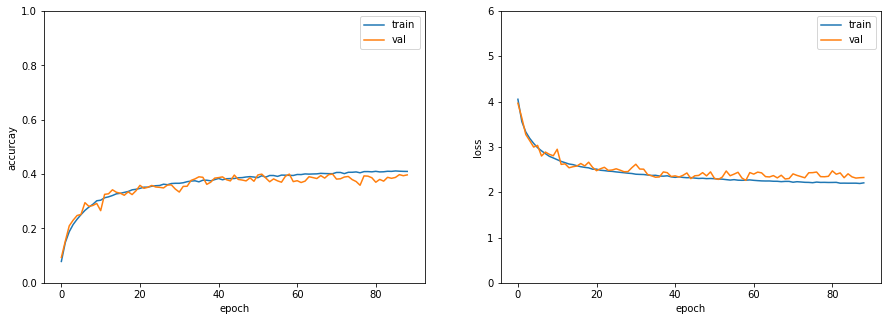

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 와우... 0.4로 성능이 좋진 않지만 과적합없고 학습이 잘됨. 여기서 성능만 오르면 좋겠는데... 필터수를 늘려볼까?? 아님 블럭당 Conv층을 하나씩 더 넣어볼까?

### 함수로 묶기

- 그래서 저걸 함수로 묶어서 filter 매개변수 넘기고 레이어 깊어질수록
- filter * 2, filter * 4 주고 8, 16, 32 하나씩 넣어가면서 성능 변화 봐보셈
 

In [ ]:
# 기존 블럭 : Conv - Bn - Act /- Conv - Bn - Add - Act / Conv층 2개 거침
def conv_bn_act_add(x, filter, size):
  conv1 = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([conv1,x])
  x = layers.Activation('relu')(x)

  return x

# Conv 추가 블럭 : Conv - Bn - Act /- Conv - Bn - Act /- Conv - Bn - Add - Act / Conv층 2개 거침
def conv_bn_act_add2(x, filter, size):
  conv1 = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([conv1,x])
  x = layers.Activation('relu')(x)

  return x

### 기존 블럭 필터수 8,16,32,64 (0.3339)

In [ ]:
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add(input,8,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

Epoch 1/400
1250/1250 [==============================] - 13s 9ms/step - loss: 4.0974 - accuracy: 0.0754 - val_loss: 3.9543 - val_accuracy: 0.0840
Epoch 2/400
1250/1250 [==============================] - 11s 8ms/step - loss: 3.6356 - accuracy: 0.1416 - val_loss: 3.7875 - val_accuracy: 0.1161
Epoch 3/400
1250/1250 [==============================] - 11s 8ms/step - loss: 3.4418 - accuracy: 0.1745 - val_loss: 3.5661 - val_accuracy: 0.1536
Epoch 4/400
1250/1250 [==============================] - 11s 9ms/step - loss: 3.3150 - accuracy: 0.1999 - val_loss: 3.4297 - val_accuracy: 0.1754
Epoch 5/400
1250/1250 [==============================] - 10s 8ms/step - loss: 3.2374 - accuracy: 0.2137 - val_loss: 3.2643 - val_accuracy: 0.2048
Epoch 6/400
1250/1250 [==============================] - 9s 7ms/step - loss: 3.1647 - accuracy: 0.2257 - val_loss: 3.2446 - val_accuracy: 0.2119
Epoch 7/400
1250/1250 [==============================] - 10s 8ms/step - loss: 3.1150 - accuracy: 0.2352 - val_loss: 3.1546 - 

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.6015 - accuracy: 0.3339


[2.6015453338623047, 0.33390000462532043]

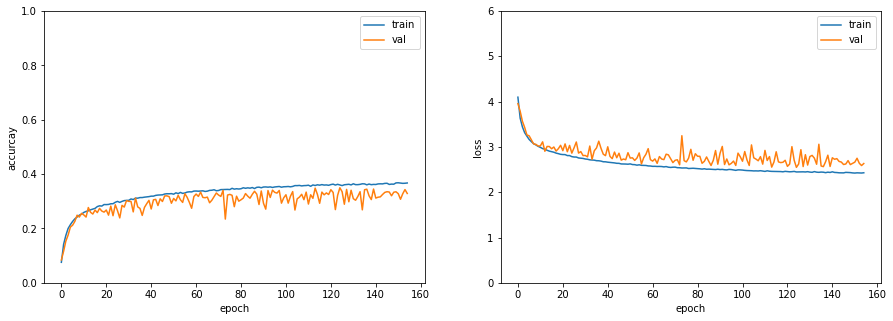

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 위의 모델에서 블럭들을 함수로 묶은 모델. 당연히 성능은 비슷하다

### 기존블럭 - 필터수 16,32,64,128 (0.4258)

- 여기서부턴 다른 계정으로 돌려서 기록이 안남아있음. 기록은 노션에 정리하고 코드만 옮겨왔다

In [ ]:
# 16,32,64,128

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add(input,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 105/400
# 1250/1250 [==============================] - 8s 6ms/step - loss: 1.8041 - accuracy: 0.5005 - val_loss: 2.2587 - val_accuracy: 0.4227
# Epoch 106/400
# 1250/1250 [==============================] - 8s 6ms/step - loss: 1.8092 - accuracy: 0.4960 - val_loss: 2.3679 - val_accuracy: 0.4044
# Epoch 107/400
# 1250/1250 [==============================] - 7s 6ms/step - loss: 1.8079 - accuracy: 0.5008 - val_loss: 2.3798 - val_accuracy: 0.4066
# Epoch 108/400
# 1250/1250 [==============================] - 8s 6ms/step - loss: 1.8037 - accuracy: 0.5010 - val_loss: 2.5599 - val_accuracy: 0.3767
# Epoch 109/400
# 1250/1250 [==============================] - 8s 6ms/step - loss: 1.8049 - accuracy: 0.5006 - val_loss: 2.2478 - val_accuracy: 0.4202
# Epoch 109: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 1s 3ms/step - loss: 2.2197 - accuracy: 0.4258
# [2.2196710109710693, 0.42579999566078186]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 기존블럭 - 필터수 32,64,128,256 (0.4726)

In [ ]:
# 32,64,128,256

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add(input,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 51/400
# 1250/1250 [==============================] - 8s 7ms/step - loss: 1.2164 - accuracy: 0.6418 - val_loss: 2.2555 - val_accuracy: 0.4636
# Epoch 52/400
# 1250/1250 [==============================] - 8s 7ms/step - loss: 1.2092 - accuracy: 0.6468 - val_loss: 2.2561 - val_accuracy: 0.4507
# Epoch 53/400
# 1250/1250 [==============================] - 8s 7ms/step - loss: 1.2148 - accuracy: 0.6440 - val_loss: 2.2585 - val_accuracy: 0.4575
# Epoch 54/400
# 1250/1250 [==============================] - 9s 7ms/step - loss: 1.1958 - accuracy: 0.6491 - val_loss: 2.2052 - val_accuracy: 0.4694
# Epoch 55/400
# 1250/1250 [==============================] - 9s 7ms/step - loss: 1.1987 - accuracy: 0.6480 - val_loss: 2.2378 - val_accuracy: 0.4584
# Epoch 55: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 1s 4ms/step - loss: 2.1785 - accuracy: 0.4726
# [2.1785013675689697, 0.4726000130176544]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 기존블럭 - 필터수 64,128,256,512 (0.4665)

In [ ]:
# 64,128,256,512

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add(input,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add(x,512,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 37/400
# 1250/1250 [==============================] - 15s 12ms/step - loss: 0.7459 - accuracy: 0.7785 - val_loss: 2.6878 - val_accuracy: 0.4596
# Epoch 38/400
# 1250/1250 [==============================] - 16s 13ms/step - loss: 0.7406 - accuracy: 0.7782 - val_loss: 2.7303 - val_accuracy: 0.4542
# Epoch 39/400
# 1250/1250 [==============================] - 16s 13ms/step - loss: 0.7467 - accuracy: 0.7777 - val_loss: 2.8014 - val_accuracy: 0.4568
# Epoch 40/400
# 1250/1250 [==============================] - 16s 13ms/step - loss: 0.7198 - accuracy: 0.7845 - val_loss: 2.7074 - val_accuracy: 0.4612
# Epoch 41/400
# 1250/1250 [==============================] - 17s 13ms/step - loss: 0.7341 - accuracy: 0.7831 - val_loss: 2.7279 - val_accuracy: 0.4561
# Epoch 41: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 2s 6ms/step - loss: 2.6746 - accuracy: 0.4665
# [2.6746206283569336, 0.46650001406669617]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### Conv 1개 추가된 블럭 - 필터수 16,32,64,128 (0.4861)

In [ ]:
# Conv 추가 블럭 : Conv - Bn - Act /- Conv - Bn - Act /- Conv - Bn - Add - Act / Conv층 2개 거침
def conv_bn_act_add2(x, filter, size):
  conv1 = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filter,size,padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([conv1,x])
  x = layers.Activation('relu')(x)

  return x

In [ ]:
# 16,32,64,128

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add2(input,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 56/400
# 1250/1250 [==============================] - 9s 8ms/step - loss: 1.2979 - accuracy: 0.6187 - val_loss: 2.1652 - val_accuracy: 0.4611
# Epoch 57/400
# 1250/1250 [==============================] - 9s 8ms/step - loss: 1.2759 - accuracy: 0.6259 - val_loss: 2.1066 - val_accuracy: 0.4784
# Epoch 58/400
# 1250/1250 [==============================] - 10s 8ms/step - loss: 1.2793 - accuracy: 0.6251 - val_loss: 2.1492 - val_accuracy: 0.4731
# Epoch 59/400
# 1250/1250 [==============================] - 9s 7ms/step - loss: 1.2716 - accuracy: 0.6249 - val_loss: 2.1340 - val_accuracy: 0.4770
# Epoch 60/400
# 1250/1250 [==============================] - 9s 7ms/step - loss: 1.2689 - accuracy: 0.6291 - val_loss: 2.1160 - val_accuracy: 0.4807
# Epoch 61/400
# 1250/1250 [==============================] - 9s 8ms/step - loss: 1.2549 - accuracy: 0.6284 - val_loss: 2.1185 - val_accuracy: 0.4766
# Epoch 61: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 1s 3ms/step - loss: 2.0547 - accuracy: 0.4861
# [2.054731607437134, 0.4860999882221222]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### Conv 1개 추가된 블럭 - 필터수 32,64,128,256  (0.5105)

In [ ]:
# 32,64,128,256

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add2(input,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 38/400
# 1250/1250 [==============================] - 12s 10ms/step - loss: 0.6286 - accuracy: 0.8021 - val_loss: 2.2798 - val_accuracy: 0.5088
# Epoch 39/400
# 1250/1250 [==============================] - 12s 10ms/step - loss: 0.6233 - accuracy: 0.8051 - val_loss: 2.3602 - val_accuracy: 0.5034
# Epoch 40/400
# 1250/1250 [==============================] - 12s 10ms/step - loss: 0.6093 - accuracy: 0.8080 - val_loss: 2.3084 - val_accuracy: 0.5116
# Epoch 41/400
# 1250/1250 [==============================] - 12s 10ms/step - loss: 0.6100 - accuracy: 0.8107 - val_loss: 2.3950 - val_accuracy: 0.4889
# Epoch 42/400
# 1250/1250 [==============================] - 14s 11ms/step - loss: 0.5881 - accuracy: 0.8139 - val_loss: 2.2347 - val_accuracy: 0.5157
# Epoch 43/400
# 1250/1250 [==============================] - 12s 10ms/step - loss: 0.5818 - accuracy: 0.8158 - val_loss: 2.3398 - val_accuracy: 0.4998
# Epoch 43: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 1s 4ms/step - loss: 2.2774 - accuracy: 0.5105
# [2.2774195671081543, 0.5105000138282776]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### Conv 1개 추가된 블럭 - 필터수 64,128,256,512 (0.5197)

In [ ]:
# 64,128,256,512

input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_bn_act_add2(input,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_bn_act_add2(x,512,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 


gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)
model_by_resnet = keras.Model(inputs=input, outputs=output)


loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=400,verbose=1, callbacks=[es])

# Epoch 33/400
# 1250/1250 [==============================] - 27s 21ms/step - loss: 0.4169 - accuracy: 0.8698 - val_loss: 2.6001 - val_accuracy: 0.5010
# Epoch 34/400
# 1250/1250 [==============================] - 27s 22ms/step - loss: 0.3857 - accuracy: 0.8785 - val_loss: 2.5344 - val_accuracy: 0.5082
# Epoch 35/400
# 1250/1250 [==============================] - 27s 21ms/step - loss: 0.3981 - accuracy: 0.8768 - val_loss: 2.5926 - val_accuracy: 0.5173
# Epoch 36/400
# 1250/1250 [==============================] - 27s 21ms/step - loss: 0.3806 - accuracy: 0.8801 - val_loss: 2.6138 - val_accuracy: 0.5170
# Epoch 37/400
# 1250/1250 [==============================] - 27s 22ms/step - loss: 0.3829 - accuracy: 0.8803 - val_loss: 2.7597 - val_accuracy: 0.4938
# Epoch 38/400
# 1250/1250 [==============================] - 27s 22ms/step - loss: 0.3697 - accuracy: 0.8851 - val_loss: 2.7200 - val_accuracy: 0.5081
# Epoch 38: early stopping

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

# 313/313 [==============================] - 2s 8ms/step - loss: 2.6295 - accuracy: 0.5197
# [2.6295218467712402, 0.5196999907493591]

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 종합

- 과적합이 커지지않도록 예방하면서 학습 성능을 올리려면 이미지에 맞는 적절한 필터수 범위를 정해야한다
- 필터수가 적을수록 과적합은 일어나지 않고 많을수록 과적합이 심해진다
- 하지만 필터수가 너무 적으면 성능이 낮게 나온다
- 모든 실험에는 Shortcut connection이 적용됨
- 블럭당 Conv층이 2개냐 3개냐를 비교함
- 필터수 범위는 32~256. DropOut 등 잘 사용해서 과적합도 줄이고 성능 올려보자
- 그리고 필터수 범위를 블럭당 2배로 올리는 것 외에도 16,32,32,32 이런식으로도 한번 해보자

## Flatten -> Gap (0.5243)
- shotcut connection 적용 - Adam(learning_rate=0.0001) (0.6289) 모델에서 Flatten 대신 Gap를, Dense-Dropout을 제거하였다

In [ ]:
# Convolution - Batch Normalization - Activation - Convolution - Batch Normalization - Activation - Dropout - Pooling

input = layers.Input(input_shape)
conv1 = layers.Conv2D(256, (3, 3),padding='same', input_shape=[32,32,3])(input)
x = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv1,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv2 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv2,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.3)(x)

conv3 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv3,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

conv4 = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(conv4)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3),padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([conv4,x])
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2))(x)
x = layers.Dropout(0.4)(x)

gap = layers.GlobalAveragePooling2D()(x)
# flatten = layers.Flatten()(x)
# dense = layers.Dense(512,activation='relu')(flatten)
# dropout = layers.Dropout(0.5)(dense)
output = layers.Dense(100,activation='softmax')(gap)

model_by_resnet = keras.Model(inputs=input, outputs=output)

loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam() # 처음엔 디폴트값 0.001 사용.
es = EarlyStopping(monitor='val_loss', verbose=1, patience= 30, restore_best_weights=True)

model_by_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model_by_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200,verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 78s 61ms/step - loss: 4.1743 - accuracy: 0.0682 - val_loss: 3.8438 - val_accuracy: 0.1033
Epoch 2/200
1250/1250 [==============================] - 77s 61ms/step - loss: 3.6009 - accuracy: 0.1475 - val_loss: 3.4960 - val_accuracy: 0.1687
Epoch 3/200
1250/1250 [==============================] - 77s 61ms/step - loss: 3.2854 - accuracy: 0.2060 - val_loss: 3.3684 - val_accuracy: 0.2051
Epoch 4/200
1250/1250 [==============================] - 75s 60ms/step - loss: 3.0144 - accuracy: 0.2526 - val_loss: 3.4982 - val_accuracy: 0.2147
Epoch 5/200
1250/1250 [==============================] - 75s 60ms/step - loss: 2.8109 - accuracy: 0.2913 - val_loss: 2.6796 - val_accuracy: 0.3251
Epoch 6/200
1250/1250 [==============================] - 75s 60ms/step - loss: 2.6439 - accuracy: 0.3228 - val_loss: 2.6303 - val_accuracy: 0.3295
Epoch 7/200
1250/1250 [==============================] - 75s 60ms/step - loss: 2.4971 - accuracy: 0.3545 - val_loss: 2

In [ ]:
model_by_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 5s 17ms/step - loss: 1.8031 - accuracy: 0.5243


[1.8031095266342163, 0.5242999792098999]

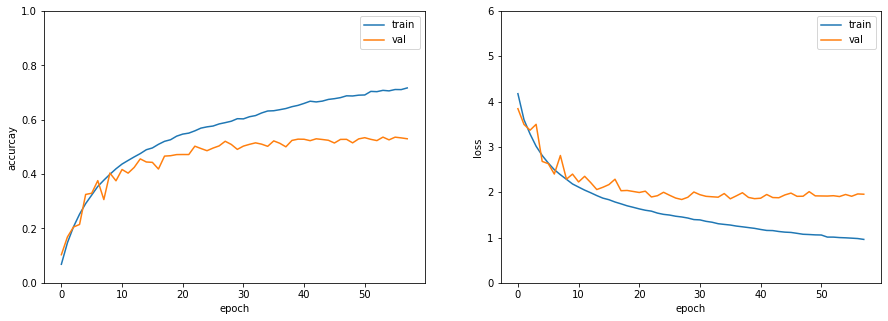

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- 역시 필터수가 과하다. Dropout으로 과적합을 잡는다고 해도 성능향상을 이루진 못한다.
- 그럼 필터수를 낮추고 shortcut connection을 이용해 층을 더 많이 쌓는다면???
- 기존에도 shortcut connection기법을 사용했지만 첫 Conv의 필터수는 128, 256 시작이였다. 
- 그럼 16, 32부터 시작해서 층을, 블럭을 더 많이 쌓으면???
- 앞에서 실험을 통해 설정한 필터수의 범위는 32~256... 이지만 이건 다음 블럭마다 필터수를 2배로 설정해서 그렇고, 블럭 2개당 같은 필터수를 주고 블럭을 더 늘려보자
- 필터수를 256, 512 크게 주면서 층을 깊게 쌓으면 과적합이 매우 심해진다. 그럼 필터수를 낮게 주고 층을 깊게 쌓으면??? 4블럭 이상 쌓아보자

- Conv에서 kernel_initializer='he_uniform' / 'he_normal' 써보기
- ReLU 대신 LeakyReLU 써보기
- 학습 스케줄러 써보기 - 지수기반, 성능기반, 1사이클 스케줄링

## 스테이지 3개(conv_block - identity_block)

In [ ]:
def identity_block(input, channels, filter_size): # input과 output의 shape가 같을때 사용.
    shortcut = input
    x = layers.Conv2D(channels,filter_size,padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    concat = layers.Add()([shortcut,x])
    x = layers.Activation('relu')(concat)

    return x

def conv_block(input, channels, filter_size): # input과 output의 shape가 다를 경우. 
    shortcut = layers.Conv2D(channels,filter_size,padding='same')(input)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(channels,filter_size,padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(channels,filter_size,padding='same')(x)
    x = layers.BatchNormalization()(x)
    concat = layers.Add()([shortcut,x])
    x = layers.Activation('relu')(concat)

    return x

- 위의 실험과 다른점은 블럭이 하나 더 추가되었다
- 위에서는 첫 Conv층을 거친 피쳐맵과 층들을 거치고 활성화 함수 들어가기전 피쳐맵을 합친 블럭 하나만 사용했다
- 여기선 두 블럭을 같은 이미지 사이즈로 유지해서 전 블럭의 아웃풋과 새 블럭의 아웃풋을 합치는 identity_block 블럭을 추가했다
- MaxPooling은 5번까지만 가능 - 이미지 사이즈때매.

### 필터8,16,32 (0.4602)

In [ ]:
# 8,16,32
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,8,3)
x = identity_block(x,8,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 16,16,64

x = conv_block(x,16,3)
x = identity_block(x,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 8,8,64

x = conv_block(x,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 21s 15ms/step - loss: 4.0753 - accuracy: 0.0719 - val_loss: 3.7838 - val_accuracy: 0.1093
Epoch 2/200
1250/1250 [==============================] - 18s 14ms/step - loss: 3.6020 - accuracy: 0.1356 - val_loss: 3.7214 - val_accuracy: 0.1270
Epoch 3/200
1250/1250 [==============================] - 17s 14ms/step - loss: 3.3354 - accuracy: 0.1794 - val_loss: 3.4476 - val_accuracy: 0.1665
Epoch 4/200
1250/1250 [==============================] - 18s 14ms/step - loss: 3.1528 - accuracy: 0.2126 - val_loss: 3.0876 - val_accuracy: 0.2239
Epoch 5/200
1250/1250 [==============================] - 17s 14ms/step - loss: 3.0063 - accuracy: 0.2388 - val_loss: 3.2305 - val_accuracy: 0.2058
Epoch 6/200
1250/1250 [==============================] - 17s 14ms/step - loss: 2.8926 - accuracy: 0.2632 - val_loss: 2.9411 - val_accuracy: 0.2565
Epoch 7/200
1250/1250 [==============================] - 18s 14ms/step - loss: 2.7988 - accuracy: 0.2830 - val_loss: 3

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 2.0556 - accuracy: 0.4602


[2.0556085109710693, 0.4602000117301941]

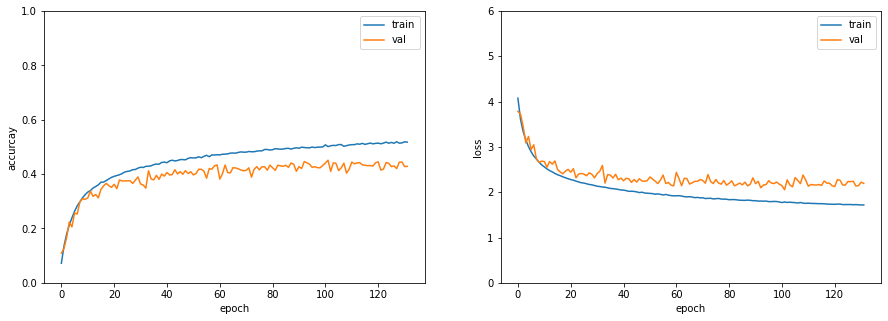

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터16,32,64 (0.5453)

In [ ]:
# 16,32,64
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,16,3)
x = identity_block(x,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 22s 15ms/step - loss: 3.9910 - accuracy: 0.0860 - val_loss: 4.3153 - val_accuracy: 0.0710
Epoch 2/200
1250/1250 [==============================] - 18s 15ms/step - loss: 3.2999 - accuracy: 0.1916 - val_loss: 3.1257 - val_accuracy: 0.2180
Epoch 3/200
1250/1250 [==============================] - 18s 15ms/step - loss: 2.8986 - accuracy: 0.2610 - val_loss: 2.8135 - val_accuracy: 0.2793
Epoch 4/200
1250/1250 [==============================] - 18s 15ms/step - loss: 2.6213 - accuracy: 0.3190 - val_loss: 2.8955 - val_accuracy: 0.2759
Epoch 5/200
1250/1250 [==============================] - 18s 14ms/step - loss: 2.4383 - accuracy: 0.3549 - val_loss: 2.3952 - val_accuracy: 0.3603
Epoch 6/200
1250/1250 [==============================] - 18s 15ms/step - loss: 2.2965 - accuracy: 0.3871 - val_loss: 2.3357 - val_accuracy: 0.3814
Epoch 7/200
1250/1250 [==============================] - 18s 15ms/step - loss: 2.1830 - accuracy: 0.4117 - val_loss: 2

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.7084 - accuracy: 0.5453


[1.7083982229232788, 0.5453000068664551]

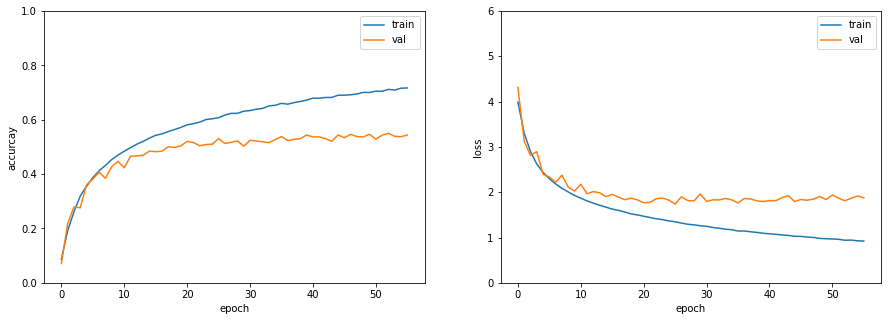

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터32,32,64 (0.5509)

In [ ]:
# 32,32,64
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 27s 20ms/step - loss: 4.0435 - accuracy: 0.0775 - val_loss: 4.0429 - val_accuracy: 0.0967
Epoch 2/200
1250/1250 [==============================] - 23s 18ms/step - loss: 3.3437 - accuracy: 0.1819 - val_loss: 3.6302 - val_accuracy: 0.1629
Epoch 3/200
1250/1250 [==============================] - 23s 18ms/step - loss: 2.8898 - accuracy: 0.2654 - val_loss: 2.7787 - val_accuracy: 0.2877
Epoch 4/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.6079 - accuracy: 0.3198 - val_loss: 2.6355 - val_accuracy: 0.3190
Epoch 5/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.4083 - accuracy: 0.3608 - val_loss: 2.3573 - val_accuracy: 0.3722
Epoch 6/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.2445 - accuracy: 0.3956 - val_loss: 2.7433 - val_accuracy: 0.3191
Epoch 7/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.1333 - accuracy: 0.4215 - val_loss: 2

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6684 - accuracy: 0.5509


[1.6684064865112305, 0.5508999824523926]

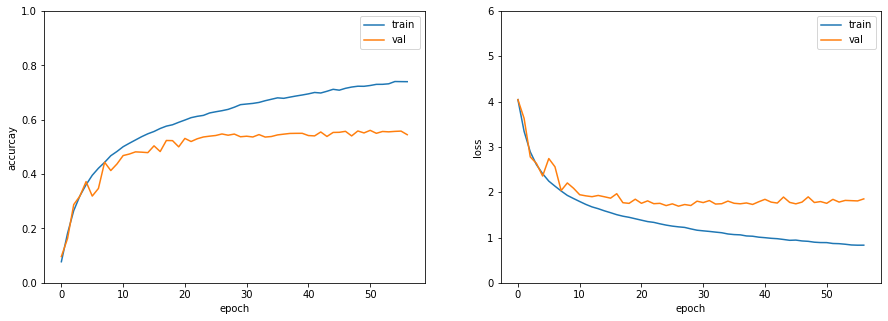

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터32,64,64 (0.5735)

In [ ]:
# 32,64,64
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 28s 20ms/step - loss: 3.9660 - accuracy: 0.0901 - val_loss: 3.9495 - val_accuracy: 0.1129
Epoch 2/200
1250/1250 [==============================] - 23s 19ms/step - loss: 3.2075 - accuracy: 0.2030 - val_loss: 3.0786 - val_accuracy: 0.2361
Epoch 3/200
1250/1250 [==============================] - 24s 19ms/step - loss: 2.7325 - accuracy: 0.2929 - val_loss: 2.8113 - val_accuracy: 0.2890
Epoch 4/200
1250/1250 [==============================] - 25s 20ms/step - loss: 2.4376 - accuracy: 0.3552 - val_loss: 2.7687 - val_accuracy: 0.2895
Epoch 5/200
1250/1250 [==============================] - 22s 17ms/step - loss: 2.2292 - accuracy: 0.3984 - val_loss: 2.3609 - val_accuracy: 0.3810
Epoch 6/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.0623 - accuracy: 0.4350 - val_loss: 2.4571 - val_accuracy: 0.3611
Epoch 7/200
1250/1250 [==============================] - 21s 17ms/step - loss: 1.9371 - accuracy: 0.4660 - val_loss: 1

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.6404 - accuracy: 0.5735


[1.6404047012329102, 0.5734999775886536]

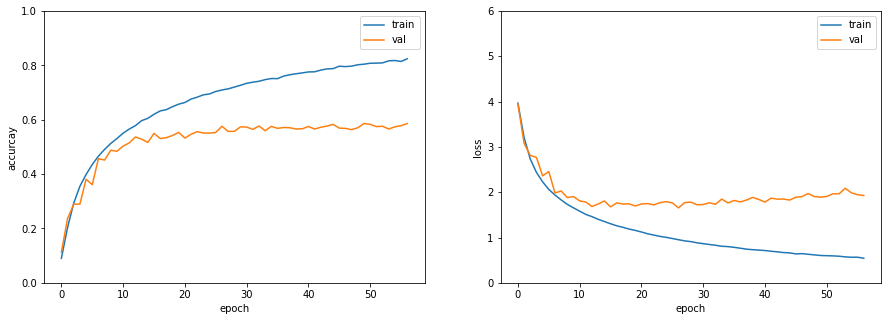

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터64,64,64 (0.5785)

In [ ]:
# 32,64,64
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.4)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 33s 24ms/step - loss: 3.9777 - accuracy: 0.0866 - val_loss: 3.6372 - val_accuracy: 0.1299
Epoch 2/200
1250/1250 [==============================] - 30s 24ms/step - loss: 3.2327 - accuracy: 0.2010 - val_loss: 3.0333 - val_accuracy: 0.2308
Epoch 3/200
1250/1250 [==============================] - 30s 24ms/step - loss: 2.7834 - accuracy: 0.2819 - val_loss: 2.7765 - val_accuracy: 0.2790
Epoch 4/200
1250/1250 [==============================] - 30s 24ms/step - loss: 2.4786 - accuracy: 0.3450 - val_loss: 2.7881 - val_accuracy: 0.2985
Epoch 5/200
1250/1250 [==============================] - 30s 24ms/step - loss: 2.2648 - accuracy: 0.3893 - val_loss: 2.4112 - val_accuracy: 0.3633
Epoch 6/200
1250/1250 [==============================] - 31s 25ms/step - loss: 2.0915 - accuracy: 0.4293 - val_loss: 2.2218 - val_accuracy: 0.4116
Epoch 7/200
1250/1250 [==============================] - 31s 25ms/step - loss: 1.9504 - accuracy: 0.4643 - val_loss: 2

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.5934 - accuracy: 0.5785


[1.593431830406189, 0.578499972820282]

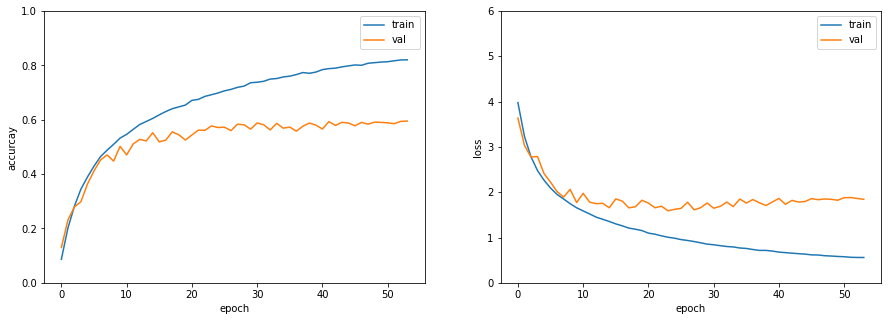

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터32,64,128 (0.5896)

In [ ]:
# 32,64,128
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) 

x = conv_block(x,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.4)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 27s 19ms/step - loss: 3.9738 - accuracy: 0.0904 - val_loss: 4.4685 - val_accuracy: 0.0762
Epoch 2/200
1250/1250 [==============================] - 22s 17ms/step - loss: 3.1394 - accuracy: 0.2168 - val_loss: 2.9918 - val_accuracy: 0.2463
Epoch 3/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.6801 - accuracy: 0.3047 - val_loss: 2.7012 - val_accuracy: 0.3082
Epoch 4/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.3737 - accuracy: 0.3690 - val_loss: 2.4640 - val_accuracy: 0.3564
Epoch 5/200
1250/1250 [==============================] - 21s 17ms/step - loss: 2.1650 - accuracy: 0.4132 - val_loss: 2.2350 - val_accuracy: 0.4039
Epoch 6/200
1250/1250 [==============================] - 22s 18ms/step - loss: 2.0013 - accuracy: 0.4536 - val_loss: 2.1021 - val_accuracy: 0.4374
Epoch 7/200
1250/1250 [==============================] - 22s 17ms/step - loss: 1.8588 - accuracy: 0.4846 - val_loss: 1

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.5459 - accuracy: 0.5896


[1.5459181070327759, 0.5896000266075134]

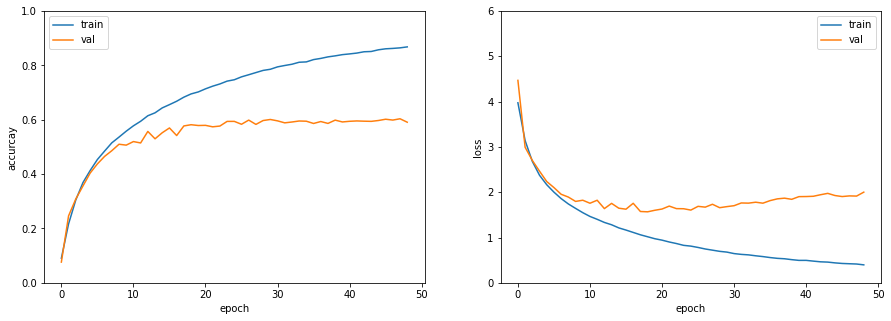

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터32,64,128 - Adam(learning_rate=0.0005) (0.5861)

In [ ]:
# 32,64,128
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) 

x = conv_block(x,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) 

x = conv_block(x,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.4)(x) 

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
1250/1250 [==============================] - 28s 20ms/step - loss: 3.9616 - accuracy: 0.0966 - val_loss: 4.0685 - val_accuracy: 0.1046
Epoch 2/200
1250/1250 [==============================] - 24s 19ms/step - loss: 3.2171 - accuracy: 0.2059 - val_loss: 3.1300 - val_accuracy: 0.2262
Epoch 3/200
1250/1250 [==============================] - 23s 19ms/step - loss: 2.7653 - accuracy: 0.2882 - val_loss: 2.6532 - val_accuracy: 0.3100
Epoch 4/200
1250/1250 [==============================] - 23s 18ms/step - loss: 2.4598 - accuracy: 0.3509 - val_loss: 2.3019 - val_accuracy: 0.3802
Epoch 5/200
1250/1250 [==============================] - 24s 20ms/step - loss: 2.2442 - accuracy: 0.3994 - val_loss: 2.1406 - val_accuracy: 0.4265
Epoch 6/200
1250/1250 [==============================] - 24s 19ms/step - loss: 2.0750 - accuracy: 0.4343 - val_loss: 2.1928 - val_accuracy: 0.4210
Epoch 7/200
1250/1250 [==============================] - 24s 19ms/step - loss: 1.9348 - accuracy: 0.4681 - val_loss: 1

In [ ]:
custom_resnet.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.5869 - accuracy: 0.5861


[1.5868901014328003, 0.5860999822616577]

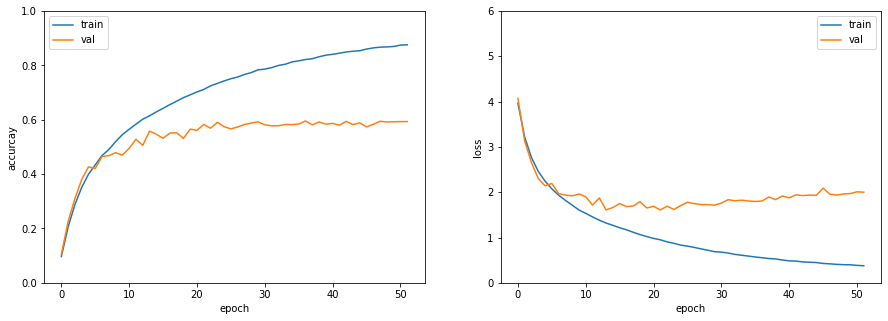

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

### 필터64,128,256 (0.5772)

In [ ]:
# 64,128,256
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,64,3)
x = identity_block(x,64,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 16,16,64

x = conv_block(x,128,3)
x = identity_block(x,128,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.3)(x) # 8,8,64

x = conv_block(x,256,3)
x = identity_block(x,256,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.4)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
flatten = layers.Flatten()(gap)
output = layers.Dense(100,activation='softmax')(flatten)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=200, verbose=1, callbacks=[es])

# Epoch 35/200
# 1250/1250 [==============================] - 43s 35ms/step - loss: 0.1745 - accuracy: 0.9423 - val_loss: 2.0142 - val_accuracy: 0.6368
# Epoch 36/200
# 1250/1250 [==============================] - 45s 36ms/step - loss: 0.1596 - accuracy: 0.9466 - val_loss: 2.1129 - val_accuracy: 0.6221
# Epoch 37/200
# 1250/1250 [==============================] - 43s 35ms/step - loss: 0.1627 - accuracy: 0.9463 - val_loss: 2.0429 - val_accuracy: 0.6335
# Epoch 38/200
# 1250/1250 [==============================] - 43s 35ms/step - loss: 0.1566 - accuracy: 0.9488 - val_loss: 1.9706 - val_accuracy: 0.6359
# Epoch 39/200
# 1249/1250 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9523Restoring model weights from the end of the best epoch: 9.
# 1250/1250 [==============================] - 43s 35ms/step - loss: 0.1491 - accuracy: 0.9522 - val_loss: 2.1263 - val_accuracy: 0.6308
# Epoch 39: early stopping

custom_resnet.evaluate(X_test, y_test)
# => loss: 1.5112 - accuracy: 0.5772

# 2022.11.15(화)

## ImageDataGenerator


---



---


[[ML] Tensorflow.Keras로 ImageDataGenerator 사용해보기](https://techblog-history-younghunjo1.tistory.com/252)

[[딥러닝] Keras ImageDataGenerator를 이용한 이미지 데이터 증강 (Data Augmentation)](https://velog.io/@ym980118/%EB%94%A5%EB%9F%AC%EB%8B%9D-Keras-ImageDataGenerator%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A6%9D%EA%B0%95-Data-Augmentation)

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

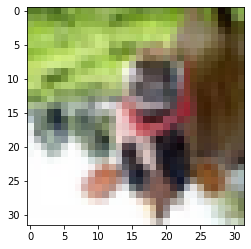

In [ ]:
data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip=True,rotation_range=0.45)

image = X_train[0]
image_batch = np.expand_dims(image,axis=0) #4차원으로 늘려주기. 배치 추가

# ImageDataGenerator 적용하려면 fit과 flow를 해야함.
data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

#실행을 위해선 next 필요
aug_image_batch = next(data_gen_iter)
aug_image = np.squeeze(aug_image_batch) # 배치때메 늘린 차원 다시 3차원으로 줄임.
aug_image = aug_image.astype('int')

# plt.imshow(image)
plt.imshow(aug_image)

### Online Augmenation

- ImageDataGenerator는 말그대로 이미지 데이터 생성기이다
- 객체 안에 넣은 기법들 중 하나를 랜덤으로 선택해서 적용한다. 그냥 원본이 나오기도 한다
- ImageDataGenerator는 랜덤으로 기법이 적용된 데이터셋을 생성하거나(이미지 증강이 아닌 변형) 데이터셋을 생성해서 원본 데이터셋에 추가하는 증강하는 방법이 있다

- [Image Augmentation - CIFAR10](https://blog.naver.com/PostView.naver?blogId=beyondlegend&logNo=222345469147&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_test = X_train/255.0, X_test/255.0

In [ ]:
# ImageDataGenerator객체 생성. 여기서 적용시킬 이미지 변형 기법들을 넣는다
gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

augment_ratio= 1.5 # 전체 데이터의 150%
augment_size = int(augment_ratio * X_train.shape[0]) # augment_size = 75000

randidx = np.random.randint(X_train.shape[0], size=augment_size) # 0~49999 사이에서 75000개의 랜덤값 반환 => 중복값 존재.

x_augmented = X_train[randidx].copy() # 데이터셋에서 랜덤으로 뽑은 인덱스들에 해당하는 이미지들 가져와서 copy.
y_augmented = y_train[randidx].copy() # 이하동일

# 랜덤으로 뽑은 이미지들을 ImageDataGenerator을 통해 이미지 변형시키고 next로 변환 실행
# 학습에 사용하는 것이 아니라 이미지를 만드는 거라 batch_size에 전체 이미지 개수, 75000개를 넣었다
# 지금은 작은 이미지라 괜찮지만 큰 이미지면 조절이 필요할 것으로 보임
# shuffle은 불필요.
x_augmented, y_augmented = gen.flow(x_augmented,y_augmented, batch_size=augment_size, shuffle=False).next()

# 변형한 데이터셋과 원본 데이터셋 합치기.
X_train = np.concatenate((X_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

# 셔플
s = np.arange(X_train.shape[0])
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

- 이렇게 비교적 간단하게 증강을 하는건 처음 봤다. 이미지 데이터들을 넘파이 배열로 바꾸기만 하면 원하는 기법들을 넣고 랜덤으로 적용시켜 데이터셋을 생성할 수 있다
- Online Augmenation이라는 편리함도 있음
---
- keras.preprocessing.image.ImageDataGenerator 클래스를 이용하면 손쉽게 디스크에서 이미지를 적재해 여러 방식으로 데이터를 증식할 수 있다
- 간단한 프로젝트일 경우에는 적합하지만 tf.data 파이프라인을 만드는 것이 장점이 더 많다

=> 전이학습 사이즈 맞추려면 필수. 언릉 보고 학습 돌리자

## OpenCV를 통한 오프라인 증강

### 회전 및 반전

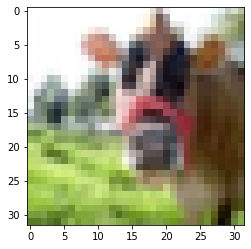

In [ ]:
img = X_train[0]
plt.imshow(img)

- 이미지 회전할 때는 아핀변환을 하는 cv2.warpAffine() 함수를 사용
- 이 때 필요한 행렬은 cv2.getRotationMatrix2D로 얻을 수 있다
- 반전은 cv2.flip(이미지, 대상 축) 사용

In [ ]:
np.array(img.shape[:2]) /2

array([16., 16.])

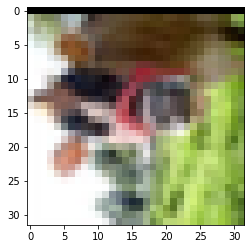

In [ ]:
img = X_train[0]
# 첫번째 인수는 회전의 중심(이미지의 중심 설정)
# 두번째 인수는 회전 각도(90, 180 등등) / 왼쪽으로 = 반시계
# 세번째 인수는 배율(2.0은 두 배, 1.0은 원본)
mat = cv2.getRotationMatrix2D(tuple(np.array(img.shape[:2]) /2), 90, 1.0)
my_img = cv2.warpAffine(img, mat, img.shape[:2])

plt.imshow(my_img)

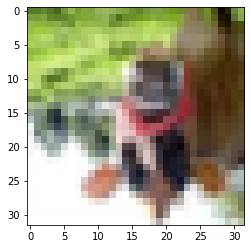

In [ ]:
# 인수가 0일때는 x축 중심으로, 양수일 때는 y축 중심으로, 음수일 때는 두축을 중심으로 반전
# 0은 위아래 반전 / 1은 좌우반전 / -1은 위아래,좌우반전
flip_img = cv2.flip(img,0)
plt.imshow(flip_img)

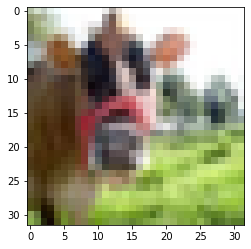

In [ ]:
# 수치는 상관없고 0, 음수, 양수만 따지는 듯. -1,0,1 이렇게만 써야겠다.
def flip_image(img,turn=1):
  flip_img = cv2.flip(img,turn)
  # plt.imshow(flip_img)
  return flip_img

plt.imshow(flip_image(X_train[0]))

### Offline Augmentation

In [ ]:
!mkdir flip_train_image

In [ ]:
def flip_image(img,turn=1):
  flip_img = cv2.flip(img,turn)
  # plt.imshow(flip_img)
  return flip_img

In [ ]:
for idx, image in enumerate(X_train):
  img = flip_image(image) # 좌우반전 
  if len(str(idx)) == 1:
    cv2.imwrite(f'/content/flip_train_image/flip_img_0000{idx}.jpeg', img)
  elif len(str(idx)) == 2:
    cv2.imwrite(f'/content/flip_train_image/flip_img_000{idx}.jpeg', img)
  elif len(str(idx)) == 3:
    cv2.imwrite(f'/content/flip_train_image/flip_img_00{idx}.jpeg', img)
  elif len(str(idx)) == 3:    
    cv2.imwrite(f'/content/flip_train_image/flip_img_0{idx}.jpeg', img)
  else:
    cv2.imwrite(f'/content/flip_train_image/flip_img_{idx}.jpeg', img)

In [ ]:
# 개수 동일. 잘 만들어짐
len(os.listdir('/content/flip_train_image')), len(os.listdir('/content/train_image'))

(50000, 50000)

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
# 증가된 이미지의 라벨 추가.
Y_train = np.concatenate((y_train,y_train))
Y_train.shape

(100000, 1)

In [ ]:
# 이미지 파일 경로들을 담은 리스트 만들기 
train_image_filenames = sorted(os.listdir('/content/train_image'))
aug_image_filenames = sorted(os.listdir('/content/flip_train_image'))
test_image_filenames = sorted(os.listdir('/content/test_image'))

train_path = '/content/train_image/'
aug_path = '/content/flip_train_image/'
test_path = '/content/test_image/'

train_image_paths, test_image_paths = [], []

for filename in tqdm(train_image_filenames):
    train_image_paths.append(train_path + filename)

for filename in tqdm(aug_image_filenames):
    train_image_paths.append(aug_path + filename)

for filename in tqdm(test_image_filenames):
    test_image_paths.append(test_path + filename)

100%|██████████| 10000/10000 [00:00<00:00, 296526.21it/s]


In [ ]:
len(train_image_paths), len(test_image_paths)

(100000, 10000)

In [ ]:
train_image_paths[49999:50005]

['/content/train_image/img_9999.jpeg',
 '/content/flip_train_image/flip_img_00000.jpeg',
 '/content/flip_train_image/flip_img_00001.jpeg',
 '/content/flip_train_image/flip_img_00002.jpeg',
 '/content/flip_train_image/flip_img_00003.jpeg',
 '/content/flip_train_image/flip_img_00004.jpeg']

In [ ]:
def preprocessing(path, label):
  image = tf.io.read_file(path)
  # image = tf.image.decode_image(image, expand_animations = False)
  image = tf.image.decode_jpeg(image)
  image = tf.image.resize(image, [224,224]) # 이걸 주석처리하면 에러나네?? 왜지??
  image = image/255.0
  return image, label

In [ ]:
X_train_paths,  X_val_paths, y_train, y_val = train_test_split(train_image_paths, Y_train, test_size=0.2, random_state=41)

In [ ]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, y_test))

train_dataset = train_dataset.shuffle(len(X_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)




```
def preprocessing(path, label):
  image = tf.io.read_file(path)
  image = tf.io.decode_image(image)
  image = tf.image.resize(image, [224,224])
  image = image/255.0
  return image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, y_test))

train_dataset = train_dataset.shuffle(len(X_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

```
일케 돌리면 



```
ValueError: in user code:

    File "<ipython-input-30-b022eed7d9ab>", line 4, in preprocessing  *
        image = tf.image.resize(image, [224,224])

    ValueError: 'images' contains no shape.
```
이런 에러가 발생한다

뭐가 문제인가 봤더니

- https://stackoverflow.com/questions/44942729/tensorflowvalueerror-images-contains-no-shape

---


It's important to pass expand_animations = False as an argument:

Try:

tf.image.decode_image(img, expand_animations = False) 
to make sure you have a tensor with a 3-dimensional shape. This problem is due to gif format because decode_gif returns a 4-D array [num_frames, height, width, 3] as opposed to other formats including decode_bmp, decode_jpeg, and decode_png, which return 3-D arrays [height, width, num_channels].

---

I faced this issue recently,

tf.image.decode_image() 
doesn't return tensor with shape, but my images were all in jpeg format.

So I used

 tf.image.decode_jpeg() 
it returns tensor with the shape and that solved the problem. Note there is tf.image.decode_png() too.


---

- tf.image.decode_image() 이 메서드는 gif까지 지원을 해서 4차원을 받는데 이미지를 넣으면 3차원이니 이미지를 쓰려면 tf.image.decode_image(img, expand_animations = False) 이렇게 써줘야 한다
- 아니면 tf.image.decode_jpeg()를 쓰는 것도 좋은 방법이다

  => 둘다 잘된다  




- 아아...데이터셋을 만들었는데 왜 돌리질 못하니... GPU 할당량...

## 전이학습(Transfer Learning)

- 케라스에 있는 모델 목록 : https://keras.io/api/applications/

### 전이학습을 위한 데이터API 공부

- tf.data.Dataset.from_tensor_slices() : 텐서를 받아 첫번째 차원을 따라 X의 각 원소가 아이템으로 표현되는 tf.data.Dataset을 만든다
- 넘파이도 들어가지네?

In [ ]:
dt = tf.data.Dataset.from_tensor_slices(X_train)
dt

<TensorSliceDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None)>

In [ ]:
# 데이터셋은 for문으로 확인할 수 있다
for i in dt:
  print(i)
  break

tf.Tensor(
[[[0.49411765 0.39607843 0.34509804]
  [0.57647059 0.4627451  0.42352941]
  [0.60392157 0.44705882 0.40784314]
  ...
  [0.69411765 0.39215686 0.23529412]
  [0.58823529 0.32941176 0.17647059]
  [0.54901961 0.21568627 0.09411765]]

 [[0.43529412 0.35294118 0.30588235]
  [0.52156863 0.40392157 0.35686275]
  [0.54509804 0.38823529 0.3372549 ]
  ...
  [0.68235294 0.35686275 0.18431373]
  [0.58823529 0.30196078 0.13333333]
  [0.60784314 0.27058824 0.09411765]]

 [[0.34117647 0.26666667 0.22352941]
  [0.38823529 0.27843137 0.22745098]
  [0.50980392 0.35686275 0.30980392]
  ...
  [0.65098039 0.31372549 0.14901961]
  [0.54901961 0.25490196 0.09019608]
  [0.59607843 0.27843137 0.11764706]]

 ...

 [[0.63137255 0.51372549 0.34117647]
  [0.69803922 0.56078431 0.38823529]
  [0.72156863 0.56862745 0.4       ]
  ...
  [0.82352941 0.55294118 0.35686275]
  [0.8627451  0.58431373 0.38039216]
  [0.88627451 0.59607843 0.38823529]]

 [[0.61568627 0.49803922 0.32941176]
  [0.67058824 0.5372549  0

In [ ]:
x = tf.range(10)
dt1 = tf.data.Dataset.from_tensor_slices(x)

for i in dt1:
  print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


- 데이터셋이 준비되면 변환 메서드를 호출하여 여러 종류의 변환을 수행할 수 있다
- 각 메서드는 새로운 데이터셋을 반환하므로 다음과 같이 변환 메서드를 연결할 수 있다

In [ ]:
dt_reapeat_batch = dt1.repeat(3).batch(7)
for i in dt_reapeat_batch:
  print(i)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


- repeat()하면 인자로 준 수만큼 반복하는 데이터셋을 생성
- 예를 들어 repeat(3)을 주면 10개가 들어있는 데이터셋을 3번 반복하는 데이터셋 생성, 안의 아이템 갯수는 30개가 된다
- 여기에 batch()를 주면 배치 갯수만큼 그룹을 지어서 꺼낸다
- batch(7)을 주면 앞의 30개를 가진 데이터셋에서 7개씩 꺼내면 7 x 4 = 28, 2개 이렇게 총 5그룹이 나온다

![d](https://pic1.zhimg.com/80/v2-3b242922714b46837ac7a5ca55c63638_1440w.webp)

- 원본 데이터셋에서 repeat() 메서드를 호출하면 원본 데이터셋의 아이템을 세 차례 반복하는 새로운 데이터셋을 반환한다
- 메모리에서 세번 복사하는 것이 아니다(repeat(), 매개변수 없으면 계속 반복)
- 새로운 데이터셋에서 batch() 메서드를 호출하면 다시 새로운 데이터셋이 만들어진다. 이 메서드는 이전 데이터셋의 아이템을 7개씩 그룹으로 묶는다
- 마지막으로 마지막 데이터셋의 아이템을 순회한다
- batch()메서드에서 출력된 마지막 배치 크기는 7이 아니라 2인데 drop_remainder=True를 주면 길이가 모자란 마지막 배치를 버리고 모든 배치를 동일한 크기로 맞춘다

- 데이터셋에 map()을 호출해 아이템을 변환할 수도 있다
- 이 함수는 데이터에 원하는 어떤 전처리 작업에도 적용할수 있다
- 이미지 크기 변환, 회전같은 복잡한 계산을 포함하기 때문에 여러 스레드로 나누어 속도를 높이는 것이 좋다
- num_parallel_calls 매개변수를 지정하면 간단하다
- map() 메서드에 전달하는 함수는 텐서플로 함수로 변환 가능해야 한다
- map() 메서드가 각 아이템에 변환을 적용한다면 apply() 메서드는 데이터셋 전체에 변환을 적용한다 

In [ ]:
map_dt = dt_reapeat_batch.map(lambda x:x*2)
for i in map_dt:
  print(i)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [ ]:
unbatch_dt = map_dt.apply(tf.data.experimental.unbatch())
for i in unbatch_dt.take(3):
  print(i)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [ ]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)

for i in dataset:
  print(i)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


### tf.Dataset 이용해서 데이터셋 만들기1

- 함수 적용없이 shuffle, batch만 적용한 데이터셋 만들기
- [NumPy 데이터 로드](https://www.tensorflow.org/tutorials/load_data/numpy?hl=ko)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)
X_train, X_val, X_test = X_train/255.0,  X_val/255.0,  X_test/255.0

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train)).batch(16)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)

In [ ]:
for i,j in train_dataset.take(1):
  print(i)
  print(j)

In [ ]:
# 8,16,32
input_shape = [32,32,3]
input = layers.Input(input_shape)

x = conv_block(input,8,3)
x = identity_block(x,8,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 16,16,64

x = conv_block(x,16,3)
x = identity_block(x,16,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 8,8,64

x = conv_block(x,32,3)
x = identity_block(x,32,3)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.2)(x) # 4,4,64

gap = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(100,activation='softmax')(gap)

custom_resnet = keras.Model(inputs=input, outputs=output)
# plot_model(custom_resnet)

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

custom_resnet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = custom_resnet.fit(train_dataset, validation_data =val_dataset,  epochs=20, verbose=1, callbacks=[es])

Epoch 1/20
2500/2500 [==============================] - 42s 16ms/step - loss: 4.1625 - accuracy: 0.0553 - val_loss: 3.8339 - val_accuracy: 0.1016
Epoch 2/20
2500/2500 [==============================] - 37s 15ms/step - loss: 3.6046 - accuracy: 0.1343 - val_loss: 3.4573 - val_accuracy: 0.1618
Epoch 3/20
2500/2500 [==============================] - 38s 15ms/step - loss: 3.3117 - accuracy: 0.1860 - val_loss: 3.3090 - val_accuracy: 0.1888
Epoch 4/20
2500/2500 [==============================] - 37s 15ms/step - loss: 3.1134 - accuracy: 0.2199 - val_loss: 3.1252 - val_accuracy: 0.2196
Epoch 5/20
2500/2500 [==============================] - 37s 15ms/step - loss: 2.9860 - accuracy: 0.2444 - val_loss: 2.9302 - val_accuracy: 0.2603
Epoch 6/20
2500/2500 [==============================] - 37s 15ms/step - loss: 2.8826 - accuracy: 0.2655 - val_loss: 2.8605 - val_accuracy: 0.2720
Epoch 7/20
2500/2500 [==============================] - 38s 15ms/step - loss: 2.7958 - accuracy: 0.2829 - val_loss: 2.7045 -

In [ ]:
custom_resnet.evaluate(test_dataset)

625/625 [==============================] - 3s 5ms/step - loss: 2.2841 - accuracy: 0.3920


[2.2840638160705566, 0.3919999897480011]

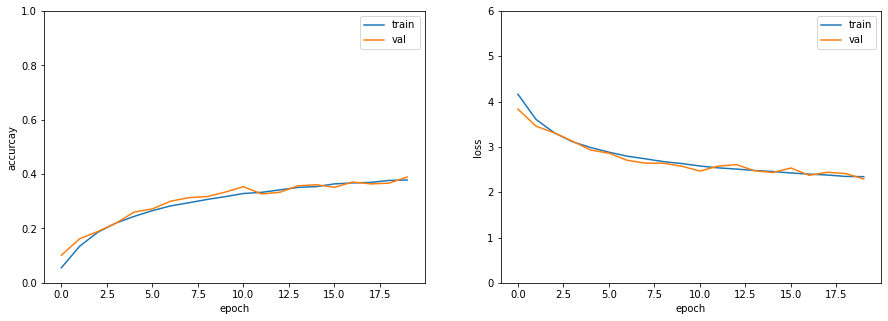

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

- tf.Dataset으로 학습까지 잘 시킴

### tf.Dataset 이용해서 데이터셋 만들기2

- map을 통해 이미지 데이터셋에만 전처리 함수 데이터에 적용
- 라벨이랑 zip으로 데이터셋 합치기
- batch, repeat, prefetch 적용

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
def resize(image, label):
  re_image = tf.image.resize(image, [224,224])
  re_image = re_image/255.0
  return re_image, label

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


- 두 함수의 차이는?? keras.applications.xception.preprocess_input을 쓰면 어떤게 다를까???

- 핸즈온 머신러닝을 참고한 Xception 전이학습

In [ ]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_dataset= test_dataset.map(preprocess).batch(batch_size).prefetch(1)

### Xception 전이학습 (0.6456)

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(100, activation='softmax')(gap)

xception = keras.Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
  layer.trainable = False

# xception.summary()

In [ ]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

xception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = xception.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
2500/2500 [==============================] - 217s 85ms/step - loss: 1.5693 - accuracy: 0.5810 - val_loss: 1.3139 - val_accuracy: 0.6354
Epoch 2/200
2500/2500 [==============================] - 207s 83ms/step - loss: 1.0496 - accuracy: 0.6952 - val_loss: 1.3001 - val_accuracy: 0.6469
Epoch 3/200
2500/2500 [==============================] - 207s 83ms/step - loss: 0.8542 - accuracy: 0.7467 - val_loss: 1.3152 - val_accuracy: 0.6456
Epoch 4/200
2500/2500 [==============================] - 207s 83ms/step - loss: 0.7145 - accuracy: 0.7865 - val_loss: 1.3380 - val_accuracy: 0.6495
Epoch 5/200
2500/2500 [==============================] - 208s 83ms/step - loss: 0.6078 - accuracy: 0.8172 - val_loss: 1.3572 - val_accuracy: 0.6493
Epoch 6/200
2500/2500 [==============================] - 207s 83ms/step - loss: 0.5212 - accuracy: 0.8461 - val_loss: 1.3752 - val_accuracy: 0.6535
Epoch 7/200
2500/2500 [==============================] - 207s 83ms/step - loss: 0.4551 - accuracy: 0.8675 - val_

In [ ]:
xception.evaluate(test_dataset)

625/625 [==============================] - 41s 65ms/step - loss: 1.2980 - accuracy: 0.6456


[1.2979999780654907, 0.6456000208854675]

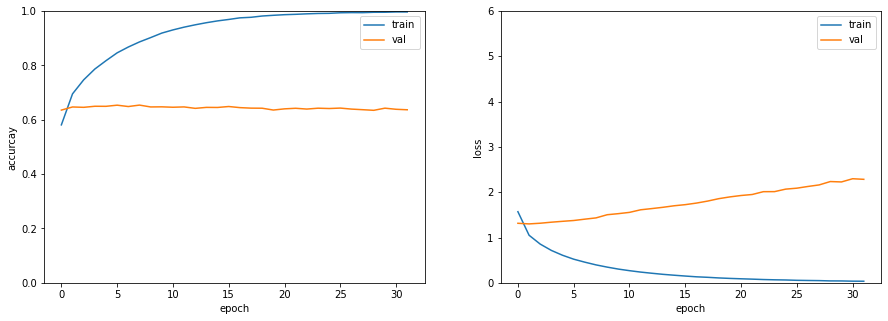

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

In [ ]:
batch_size = 16

train_image = tf.data.Dataset.from_tensor_slices(X_train)
train_image = train_image.map(resize)
train_label = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_image, train_label))

val_image = tf.data.Dataset.from_tensor_slices(X_val)
val_image = val_image.map(resize)
val_label = tf.data.Dataset.from_tensor_slices(y_val)
val_dataset = tf.data.Dataset.zip((val_image, val_label))

test_image = tf.data.Dataset.from_tensor_slices(X_test)
test_image = test_image.map(resize)
test_label = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_image, test_label))


train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(1)
val_dataset = train_dataset.batch(batch_size).prefetch(1)
test_dataset = train_dataset.batch(batch_size).prefetch(1)


# train_dataset = train_dataset.repeat()
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


위에 있는대로 데이터셋을 만들고 모델을 돌리면 렘이 터짐! 뭐가 문제일까??

```
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(resize).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(resize).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(resize).batch(batch_size).prefetch(1)
```

ㄴ 이렇게 하면 잘 돌아감



ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).

- [steps_per_epoch 값 정하기](https://foxtrotin.tistory.com/535)

In [ ]:
batch_size = 16
steps_per_epoch = len(X_train)//batch_size
steps_per_epoch

3125

# 2022.11.16(수)

## MobileNetV2 (0.5984)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

# def resize(image, label):
#   re_image = tf.image.resize(image, [224,224])
#   re_image = re_image/255.0
#   return re_image, label

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = tf.keras.applications.mobilenet_v2.preprocess_input(resized_image)
  return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_dataset= test_dataset.map(preprocess).batch(batch_size).prefetch(1)

###########################################################################
base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(100, activation='softmax')(gap)

MobileNetV2 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

MobileNetV2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = MobileNetV2.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es])

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/200
2500/2500 [==============================] - 72s 27ms/step - loss: 1.7928 - accuracy: 0.5299 - val_loss: 1.4870 - val_accuracy: 0.6010
Epoch 2/200
2500/2500 [==============================] - 66s 26ms/step - loss: 1.2315 - accuracy: 0.6532 - val_loss: 1.5124 - val_accuracy: 0.6042
Epoch 3/200
2500/2500 [==============================] - 66s 26ms/step - loss: 1.0520 - accuracy: 0.6998 - val_loss: 1.5106 - val_accuracy: 0.6088
Epoch 4/200
2500/2500 [==============================] - 66s 26ms/step - loss: 0.9104 - accuracy: 0.7326 - val_loss: 1.5485 - val_accuracy: 0.6153
Epoch 5/200
2500/2500 [==============================] - 66s 26ms/step - loss: 0.8190 - accuracy: 0.7561 - val_loss: 1.6165 - val_accuracy: 0.6115
Epoch 6/200
2500/2500 [==============================] - 63s 25ms/step - loss: 0.7265 - accuracy: 0.7789 - val_loss: 1.5758 - val_accuracy: 0.6204
Epoch 7/200
2500/2500 [==============================] 

In [ ]:
MobileNetV2.evaluate(test_dataset)

625/625 [==============================] - 13s 20ms/step - loss: 1.4898 - accuracy: 0.5984


[1.4897559881210327, 0.5983999967575073]

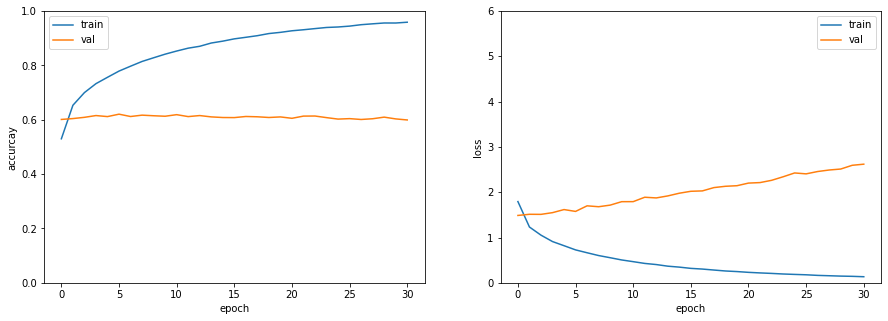

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## DenseNet121 (0.6820)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

# def resize(image, label):
#   re_image = tf.image.resize(image, [224,224])
#   re_image = re_image/255.0
#   return re_image, label

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = tf.keras.applications.densenet.preprocess_input(resized_image)
  return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_dataset= test_dataset.map(preprocess).batch(batch_size).prefetch(1)

###########################################################################
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(100, activation='softmax')(gap)

DenseNet121 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

DenseNet121.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = DenseNet121.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es])

29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/200
2500/2500 [==============================] - 162s 62ms/step - loss: 1.6131 - accuracy: 0.5708 - val_loss: 1.1778 - val_accuracy: 0.6630
Epoch 2/200
2500/2500 [==============================] - 167s 67ms/step - loss: 1.0285 - accuracy: 0.6990 - val_loss: 1.1446 - val_accuracy: 0.6760
Epoch 3/200
2500/2500 [==============================] - 156s 62ms/step - loss: 0.8945 - accuracy: 0.7355 - val_loss: 1.1127 - val_accuracy: 0.6793
Epoch 4/200
2500/2500 [==============================] - 150s 60ms/step - loss: 0.8113 - accuracy: 0.7574 - val_loss: 1.1821 - val_accuracy: 0.6709
Epoch 5/200
2500/2500 [==============================] - 147s 59ms/step - loss: 0.7471 - accuracy: 0.7767 - val_loss: 1.1558 - val_accuracy: 0.6790
Epoch 6/200
2500/2500 [==============================] - 148s 59ms/step - loss: 0.7052 - accuracy: 0.7867 - val_loss: 1.1669 - val_accuracy: 0.6837
Epoch 7/200
2500/2500 [========================

In [ ]:
DenseNet121.evaluate(test_dataset)

625/625 [==============================] - 30s 48ms/step - loss: 1.1231 - accuracy: 0.6820


[1.1230987310409546, 0.6819999814033508]

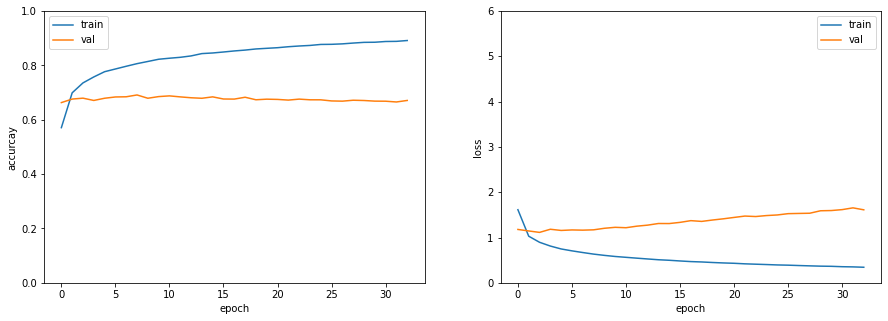

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))

## EfficientNetB0 (0.7252)

In [10]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

# def resize(image, label):
#   re_image = tf.image.resize(image, [224,224])
#   re_image = re_image/255.0
#   return re_image, label

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = tf.keras.applications.efficientnet.preprocess_input(resized_image) # 흠... 스케일링 한거랑 안한거 성능 차이 보고 결정하자
  # final_image = resized_image/255
  # final_image = (final_image-127.5)/127.5
  return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_dataset= test_dataset.map(preprocess).batch(batch_size).prefetch(1)

###########################################################################
base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(100, activation='softmax')(gap)

EfficientNetB0 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

EfficientNetB0.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = EfficientNetB0.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es])

Epoch 1/200
2500/2500 [==============================] - 121s 45ms/step - loss: 1.4818 - accuracy: 0.6087 - val_loss: 1.0734 - val_accuracy: 0.6926
Epoch 2/200
2500/2500 [==============================] - 107s 43ms/step - loss: 0.9687 - accuracy: 0.7226 - val_loss: 0.9973 - val_accuracy: 0.7152
Epoch 3/200
2500/2500 [==============================] - 104s 42ms/step - loss: 0.8215 - accuracy: 0.7599 - val_loss: 0.9706 - val_accuracy: 0.7228
Epoch 4/200
2500/2500 [==============================] - 101s 40ms/step - loss: 0.7266 - accuracy: 0.7857 - val_loss: 0.9685 - val_accuracy: 0.7271
Epoch 5/200
2500/2500 [==============================] - 101s 40ms/step - loss: 0.6622 - accuracy: 0.8032 - val_loss: 0.9652 - val_accuracy: 0.7302
Epoch 6/200
2500/2500 [==============================] - 101s 40ms/step - loss: 0.6098 - accuracy: 0.8185 - val_loss: 0.9696 - val_accuracy: 0.7316
Epoch 7/200
2500/2500 [==============================] - 101s 41ms/step - loss: 0.5666 - accuracy: 0.8289 - val_

In [11]:
EfficientNetB0.evaluate(test_dataset)

625/625 [==============================] - 21s 33ms/step - loss: 0.9622 - accuracy: 0.7252


[0.9621583819389343, 0.7251999974250793]

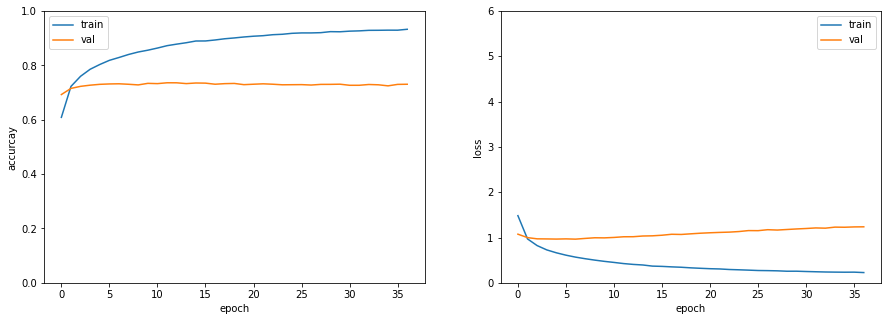

In [12]:
show_loss_acc(history, (0,1.0),(0,6))

- 흠... 전처리 함수에서 각 모델에서 제시하는 메서드 (tf.keras.applications.efficientnet.preprocess_input)를 쓰지 않고 내 임의대로 함수를 만들어서 사용하면 성능이 아예 안나온다... 왜일까?? 일부층 동결을 풀면 다를까?? 저 메서드 없이는 전이학습의 성능이 안나오나???
- 대부분의 전이학습시 분류기만 바꾸고 모든 층들을 동결시켜서 그런지 성능변화폭은 거의 없다. 우선은 전이학습으로 모델 여러개 돌려보고 높은순으로 3~5개 정도 선택한 후에 동결층에서 몇 층 정도 풀어서 학습하는 fin-tune이나 Augmentation등의 기법등을 적용시키고 최종적으로 앙상블 시킨다 

## EfficientNetB1

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

# def resize(image, label):
#   re_image = tf.image.resize(image, [224,224])
#   re_image = re_image/255.0
#   return re_image, label

def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = tf.keras.applications.efficientnet.preprocess_input(resized_image) # 흠... 스케일링 한거랑 안한거 성능 차이 보고 결정하자
  # final_image = resized_image/255
  # final_image = (final_image-127.5)/127.5
  return final_image, label

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(1)
test_dataset= test_dataset.map(preprocess).batch(batch_size).prefetch(1)

###########################################################################
base_model = keras.applications.EfficientNetB1(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(100, activation='softmax')(gap)

EfficientNetB1 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)

EfficientNetB1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = EfficientNetB1.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es])

27018416/27018416 [==============================] - 3s 0us/step
Epoch 1/200
 658/1250 [==============>...............] - ETA: 52s - loss: 1.7371 - accuracy: 0.5783

In [ ]:
EfficientNetB1.evaluate(test_dataset)

In [ ]:
show_loss_acc(history, (0,1.0),(0,6))